# Import & Setting

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from scipy import stats
from matplotlib import style
import math
style.use('ggplot')
import datetime

In [2]:
# 노트북에 plot 그리기
%matplotlib inline    
# plot의 글씨 선명하게
%config InlineBackend.figure_format = 'retina'  

plt. style.use('ggplot')

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name) # Mac의 경우는 AppleGothic, 윈도우의 경우는 Malgun Gothic을 사용하면 됩니다 :) 
mpl.rc('axes', unicode_minus=False)

In [3]:
pd.set_option('display.max_columns', 40)

In [4]:
pd.set_option('display.max_rows', 500)

# 사용자 지정 함수

In [5]:
# , 제거
def delcom(x):
    result = x.replace(',','')
    return result

# DATA_load

In [6]:
product=pd.read_csv('01_Pruduct.csv')  # 오류는 밑에서 전처리 할것임
search1=pd.read_csv('02_Search1.csv')
search2=pd.read_csv('03_Search2.csv',parse_dates=["SESS_DT"])
custom=pd.read_csv('04_Custom.csv')
session=pd.read_csv('05_Session.csv',parse_dates=["SESS_DT"])
master=pd.read_csv('06_Master.csv')

C:\Users\meuch\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 전처리

- product

In [7]:
# CT가 형태가 혼합이 되어있다. STR로 변환 후 컴마 제거 후 INT로 변경
product['PD_BUY_CT']=product['PD_BUY_CT'].astype('str')
product['PD_BUY_AM']=product['PD_BUY_AM'].apply(delcom)
product['PD_BUY_CT']=product['PD_BUY_CT'].apply(delcom)
product['PD_BUY_AM']=product['PD_BUY_AM'].astype('int')
product['PD_BUY_CT']=product['PD_BUY_CT'].astype('int')


#총판매량 추가
product['PD_BUY_TOTAL']=product['PD_BUY_AM']*product['PD_BUY_CT']

#[] 제거
product['PD_BRA_NM']=product['PD_BRA_NM'].apply(lambda x : x.translate({ord('['):'',
                                                   ord(']'):''}))


- session

In [8]:
session['TOT_SESS_HR_V']=session['TOT_SESS_HR_V'].astype('str')
session['TOT_SESS_HR_V']=session['TOT_SESS_HR_V'].apply(delcom)
session['TOT_SESS_HR_V']=session['TOT_SESS_HR_V'].astype('float')

# 병합

In [9]:
# product + session
prod_sess=pd.merge(product,session,on=['CLNT_ID','SESS_ID'])

In [10]:
# product + session + master
psm=pd.merge(prod_sess,master,on='PD_C')
del prod_sess  # 메모리절약

In [11]:
# product + session + master + custom
pscm=pd.merge(psm,custom,on='CLNT_ID',how='left')
del psm   # 메모리절약

# 변수선택

In [12]:
pscm=pscm.drop(['CLAC2_NM','CLAC3_NM'],axis=1)

In [13]:
# 시간에 따라 변화하는그래프를 그리기 위해서 COUNT_DAY를 추가해준다.
pscm['COUNT_DAY']=pscm['SESS_DT'].apply(lambda x: x.toordinal())

In [14]:
pscm['year']=pscm['SESS_DT'].dt.year
pscm['month']=pscm['SESS_DT'].dt.month
pscm['day']=pscm['SESS_DT'].dt.day

In [15]:
pscm['PD_BUY_TOTAL']=pscm['PD_BUY_AM']*pscm['PD_BUY_CT']

# 결측치 처리

In [16]:
# TOT_SESS_HR_V 와 TOT_PAG_VIEW_CT에 결측지가 있는 자료는 제외
pscm=pscm[~((pscm['TOT_SESS_HR_V'].isnull()) | (pscm['TOT_PAG_VIEW_CT'].isnull()))].reset_index()

----

# 분석---------------------------------------------------------------------------------------------

In [17]:
pscm.columns

Index(['index', 'CLNT_ID', 'SESS_ID', 'HITS_SEQ', 'PD_C', 'PD_ADD_NM',
       'PD_BRA_NM', 'PD_BUY_AM', 'PD_BUY_CT', 'PD_BUY_TOTAL', 'SESS_SEQ',
       'SESS_DT', 'TOT_PAG_VIEW_CT', 'TOT_SESS_HR_V', 'DVC_CTG_NM', 'ZON_NM',
       'CITY_NM', 'PD_NM', 'CLAC1_NM', 'CLNT_GENDER', 'CLNT_AGE', 'COUNT_DAY',
       'year', 'month', 'day'],
      dtype='object')

# Ⅰ. 제품 인기도

## ⅰ. 지역별

- 지역별 판매 횟수 지도그리기


In [18]:
import geopandas as gpd
import os

# conda install geopandas
# conda install descartes

In [33]:
where=['강원도','경기도','경상남도','경상북도','광주광역시','대구광역시','대전광역시','부산광역시','서울특별시',
      '세종특별자치시','울산광역시','인천광역시','전라남도','전라북도','제주특별자치도','충청남도','충청북도']

In [34]:
map_data=pd.DataFrame()

In [35]:
for i in range(len(where)):
    map_dir='D:/08_BA_project/lpoint/5th_lpoint_data/korea_location/'+where[i]

    file_name=os.listdir(map_dir)[1]
    
    dir_filename=map_dir+'/'+file_name
    
    data = gpd.read_file(dir_filename, encoding='euckr')
    map_data=pd.concat([map_data,data],axis=0)

In [36]:
map_data.geometry = map_data.buffer(0.001)

In [37]:
map_data = map_data.dissolve(by='SIG_CD')

In [38]:
to_eng=session['ZON_NM'].unique()

In [39]:
map_do=map_data['CTP_KOR_NM'].unique()
map_do=np.delete(map_do,7)

In [40]:
to_kor=['대전광역시','부산광역시','경기도','서울특별시','경상북도','전라북도','충청북도','강원도',
        '충청남도','인천광역시','대구광역시','광주광역시','경상남도','제주특별자치도','전라남도','울산광역시']

In [41]:
dic=dict(zip(to_eng,to_kor))

In [44]:
do_cnt=pscm.pivot_table(index='ZON_NM',
                    values='CITY_NM',
                   aggfunc='count').reset_index()
do_cnt['KOR_DO']=do_cnt.replace({"ZON_NM":dic})['ZON_NM']
do_cnt=do_cnt.rename(columns={'CITY_NM':'CNT'})
do_cnt=do_cnt.sort_values('CNT')       
do_cnt['color']=do_cnt['CNT'].apply(lambda x: str(math.floor(x/10000))+'만')
do_cnt['color']=['0'*(len(max(do_cnt['color'], key=len))-len(do_cnt['color'].iloc[x]))+do_cnt['color'].iloc[x] for x in range(len(do_cnt))]

In [45]:
dic2=dict(zip(do_cnt["KOR_DO"],do_cnt["color"]))
dic2['세종특별자치시'] = do_cnt[do_cnt['KOR_DO']=='충청북도']['color'].iloc[0]

In [46]:
map_data['COLOR']=map_data.replace({"CTP_KOR_NM":dic2})['CTP_KOR_NM']
map_data['COLOR']=map_data['COLOR'].astype('str')

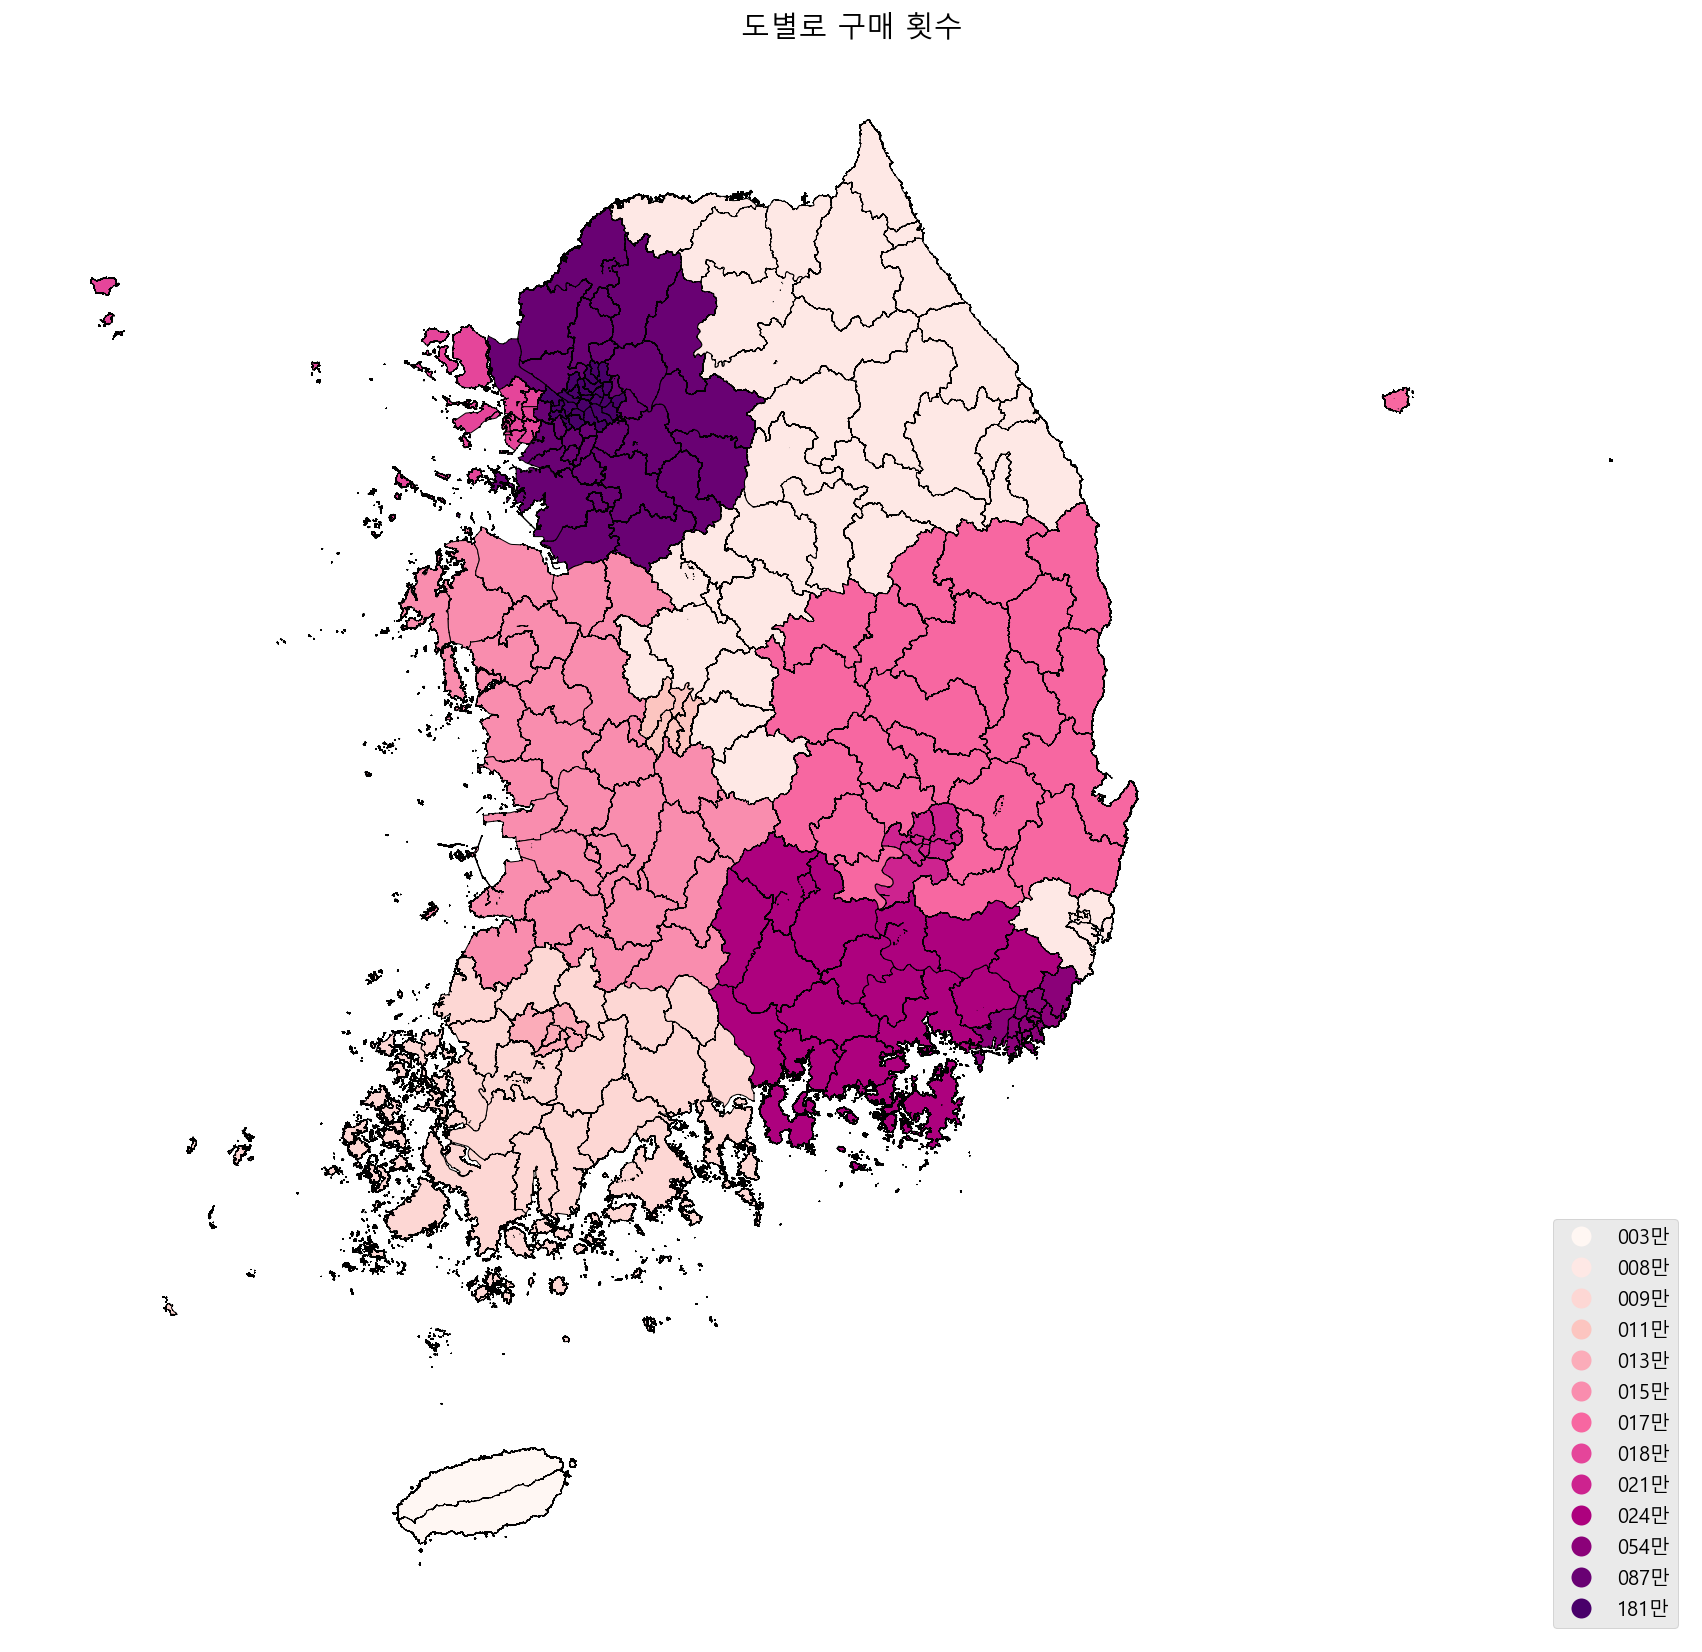

In [47]:
ax = map_data.plot(figsize=(15, 15), column="COLOR", categorical=True,
                cmap="RdPu", edgecolor="k", legend=True, legend_kwds={'loc': 4},
                  label=dic2.keys())

ax.set_title("도별로 구매 횟수")
ax.set_axis_off()
plt.show()

In [ ]:
del map_data

서울과 부산이 인구가 많아서 카운딩 된 숫자는 절대적으로 많을 수 밖에 없을 것이다.

구매 비율을 구하기 위해서는 각 인구별로 나누어 비율을 따져보아야 하지만,

판매 횟수가 많다는 것은 그만큼 그 지역에 물량이 확보되어야 한다는 뜻이다. 횟수 비교도 의미있는 비교이다

----

## ⅱ. 월별 대분류

In [18]:
cat=pscm['CLAC1_NM'].unique()
print(len(cat))
cat

37


array(['화장품/뷰티케어', '스포츠패션', '퍼스널케어', '유아동의류', '패션잡화', '아웃도어/레저', '시즌스포츠',
       '여성의류', '남성의류', '생활/주방가전', '침구/수예', '출산/육아용품', '식기/조리기구', '모바일',
       '완구', '속옷/양말/홈웨어', '건강식품', '과일', '음료', '청소/세탁/욕실용품', '문구/사무용품',
       '주방잡화', '상품권', '원예/애완', '인테리어/조명', '냉동식품', '구기/필드스포츠', '세제/위생',
       '영상/음향가전', '계절가전', '냉장/세탁가전', '가구', '냉장식품', '컴퓨터', '헬스/피트니스',
       '축산물', '자동차용품'], dtype=object)

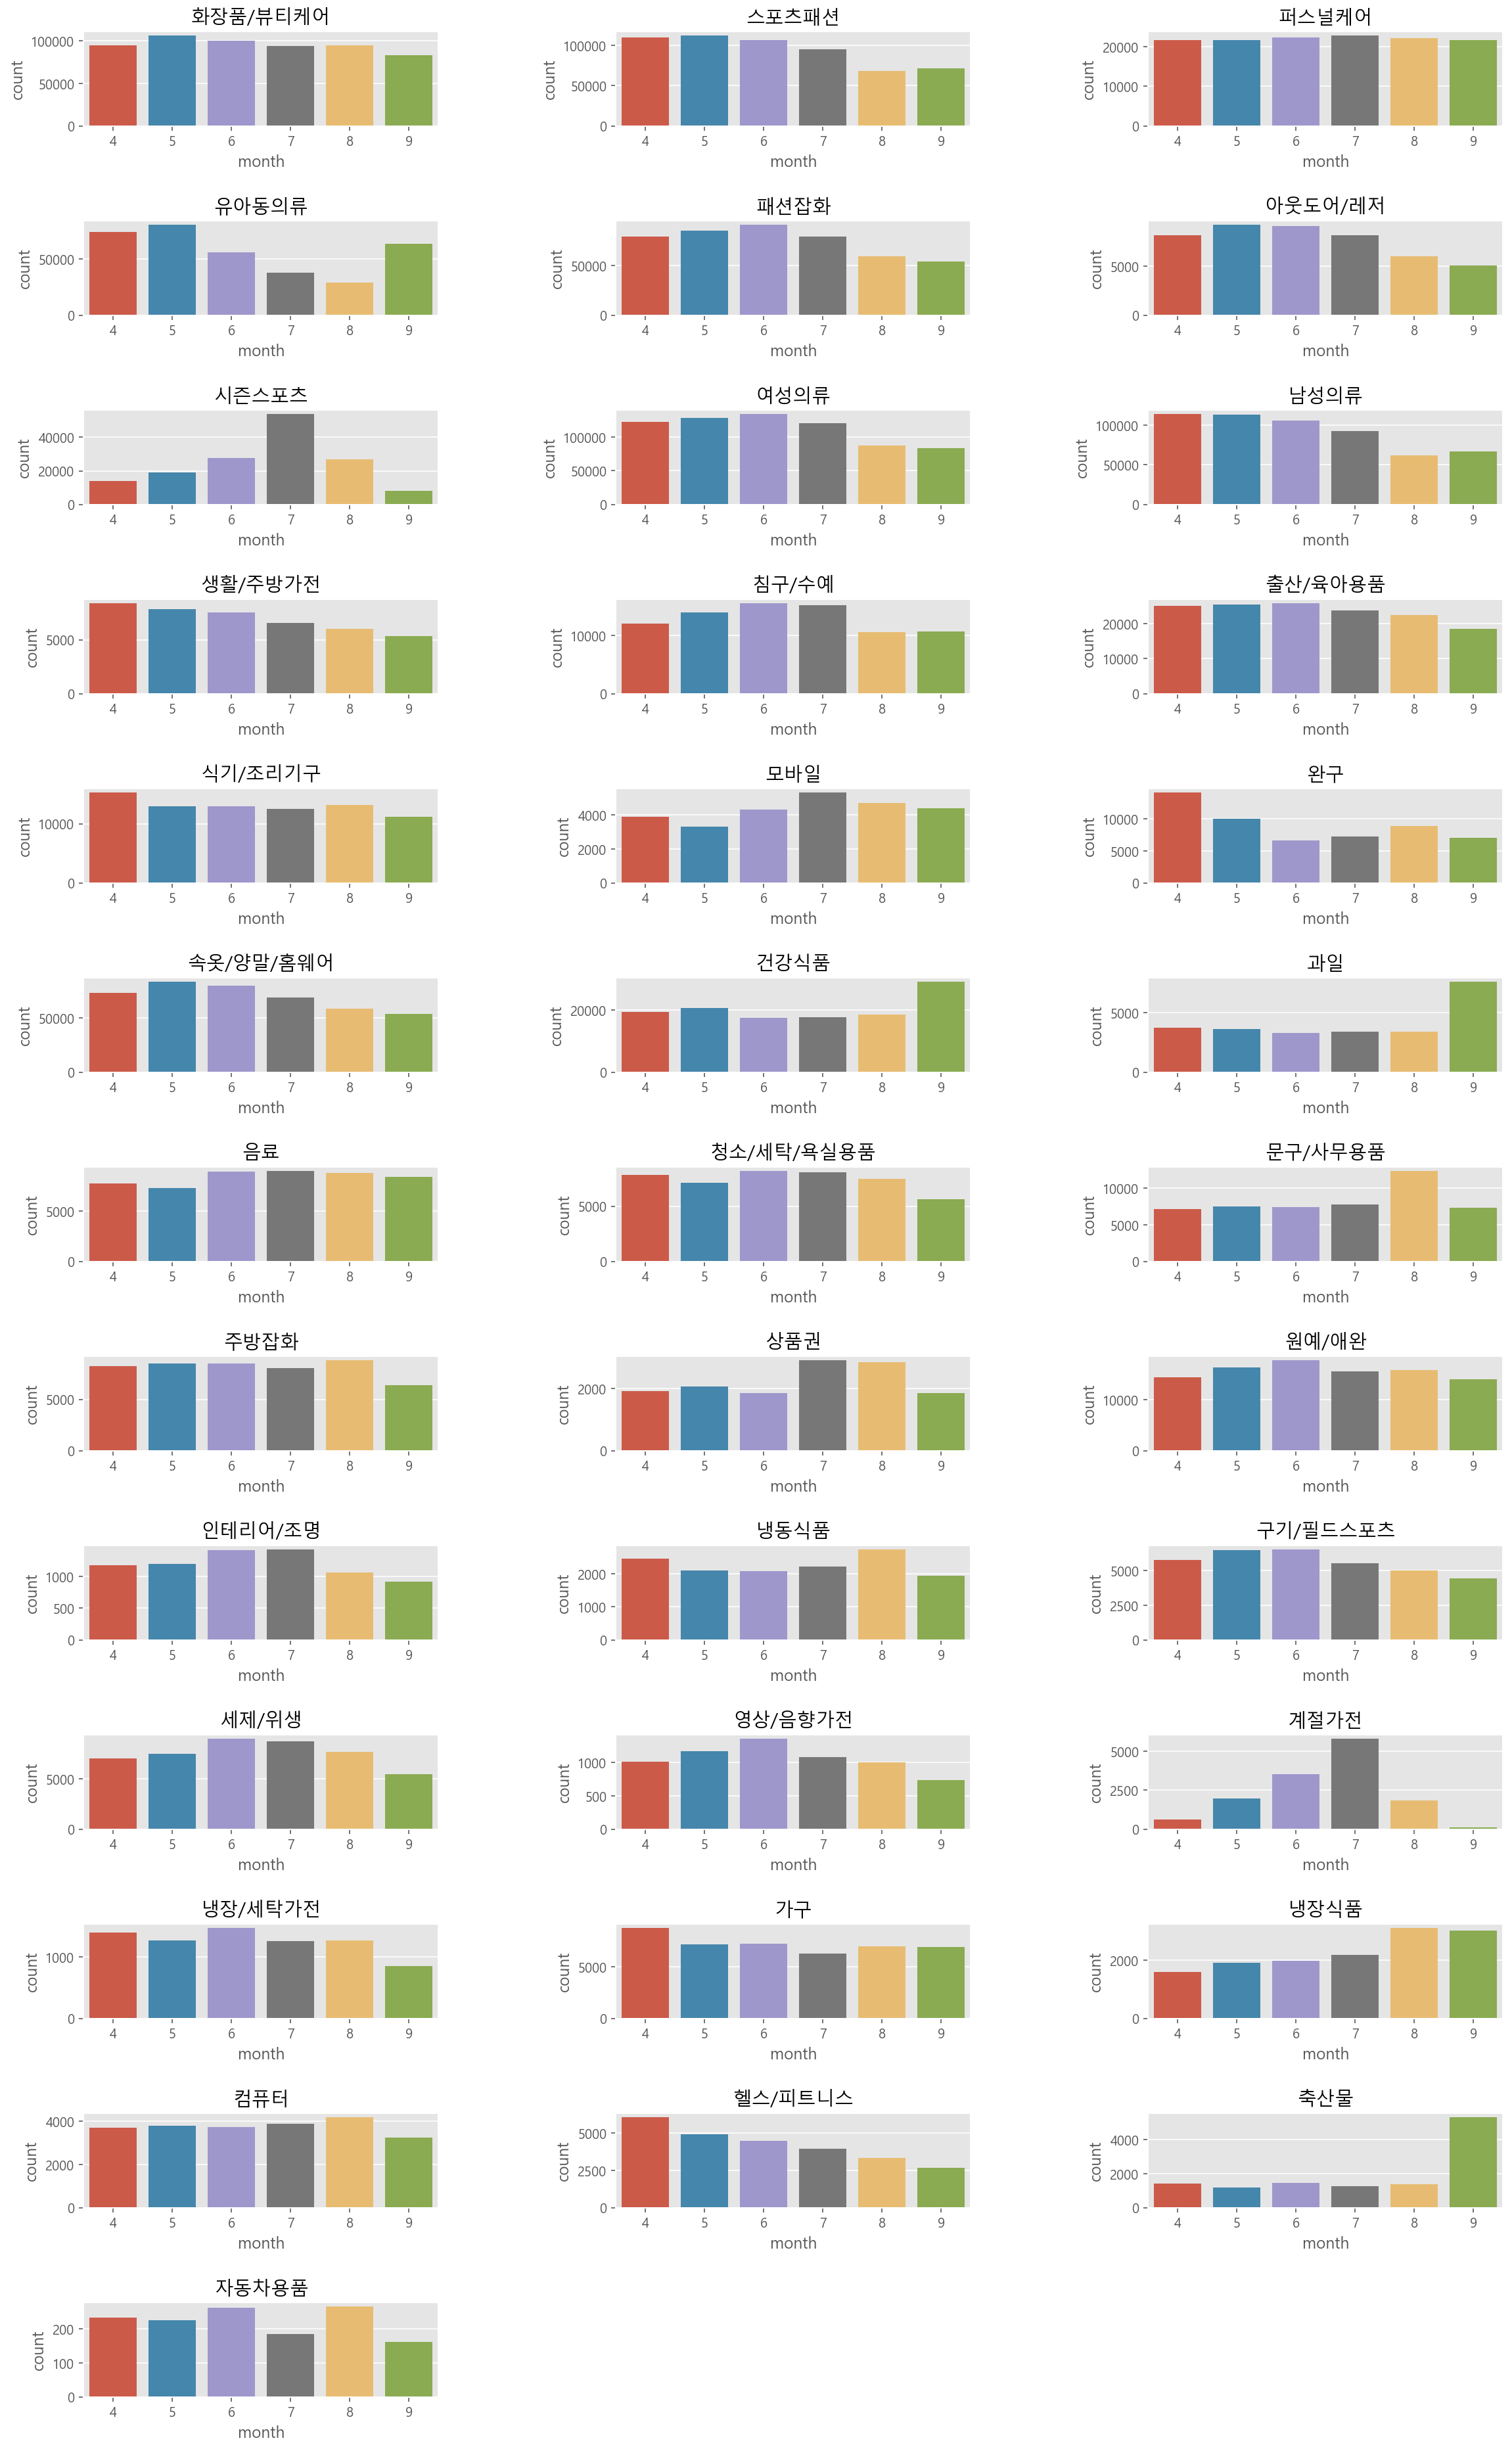

In [19]:
# 월별 cat1 별 판매 횟수
plt.figure(figsize=[15,25])
plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 1, wspace = 0.5)
cols = 3
rows = 13 

for i in range(1,38):
    plt.subplot(rows, cols, i)
    plt.title(cat[i-1])  
    df_cat=pscm[pscm['CLAC1_NM']==cat[i-1]]
    sns.countplot(data=df_cat,x='month')
    # 경향을 보기 위해 ylim은 건드리지 않음
plt.show()

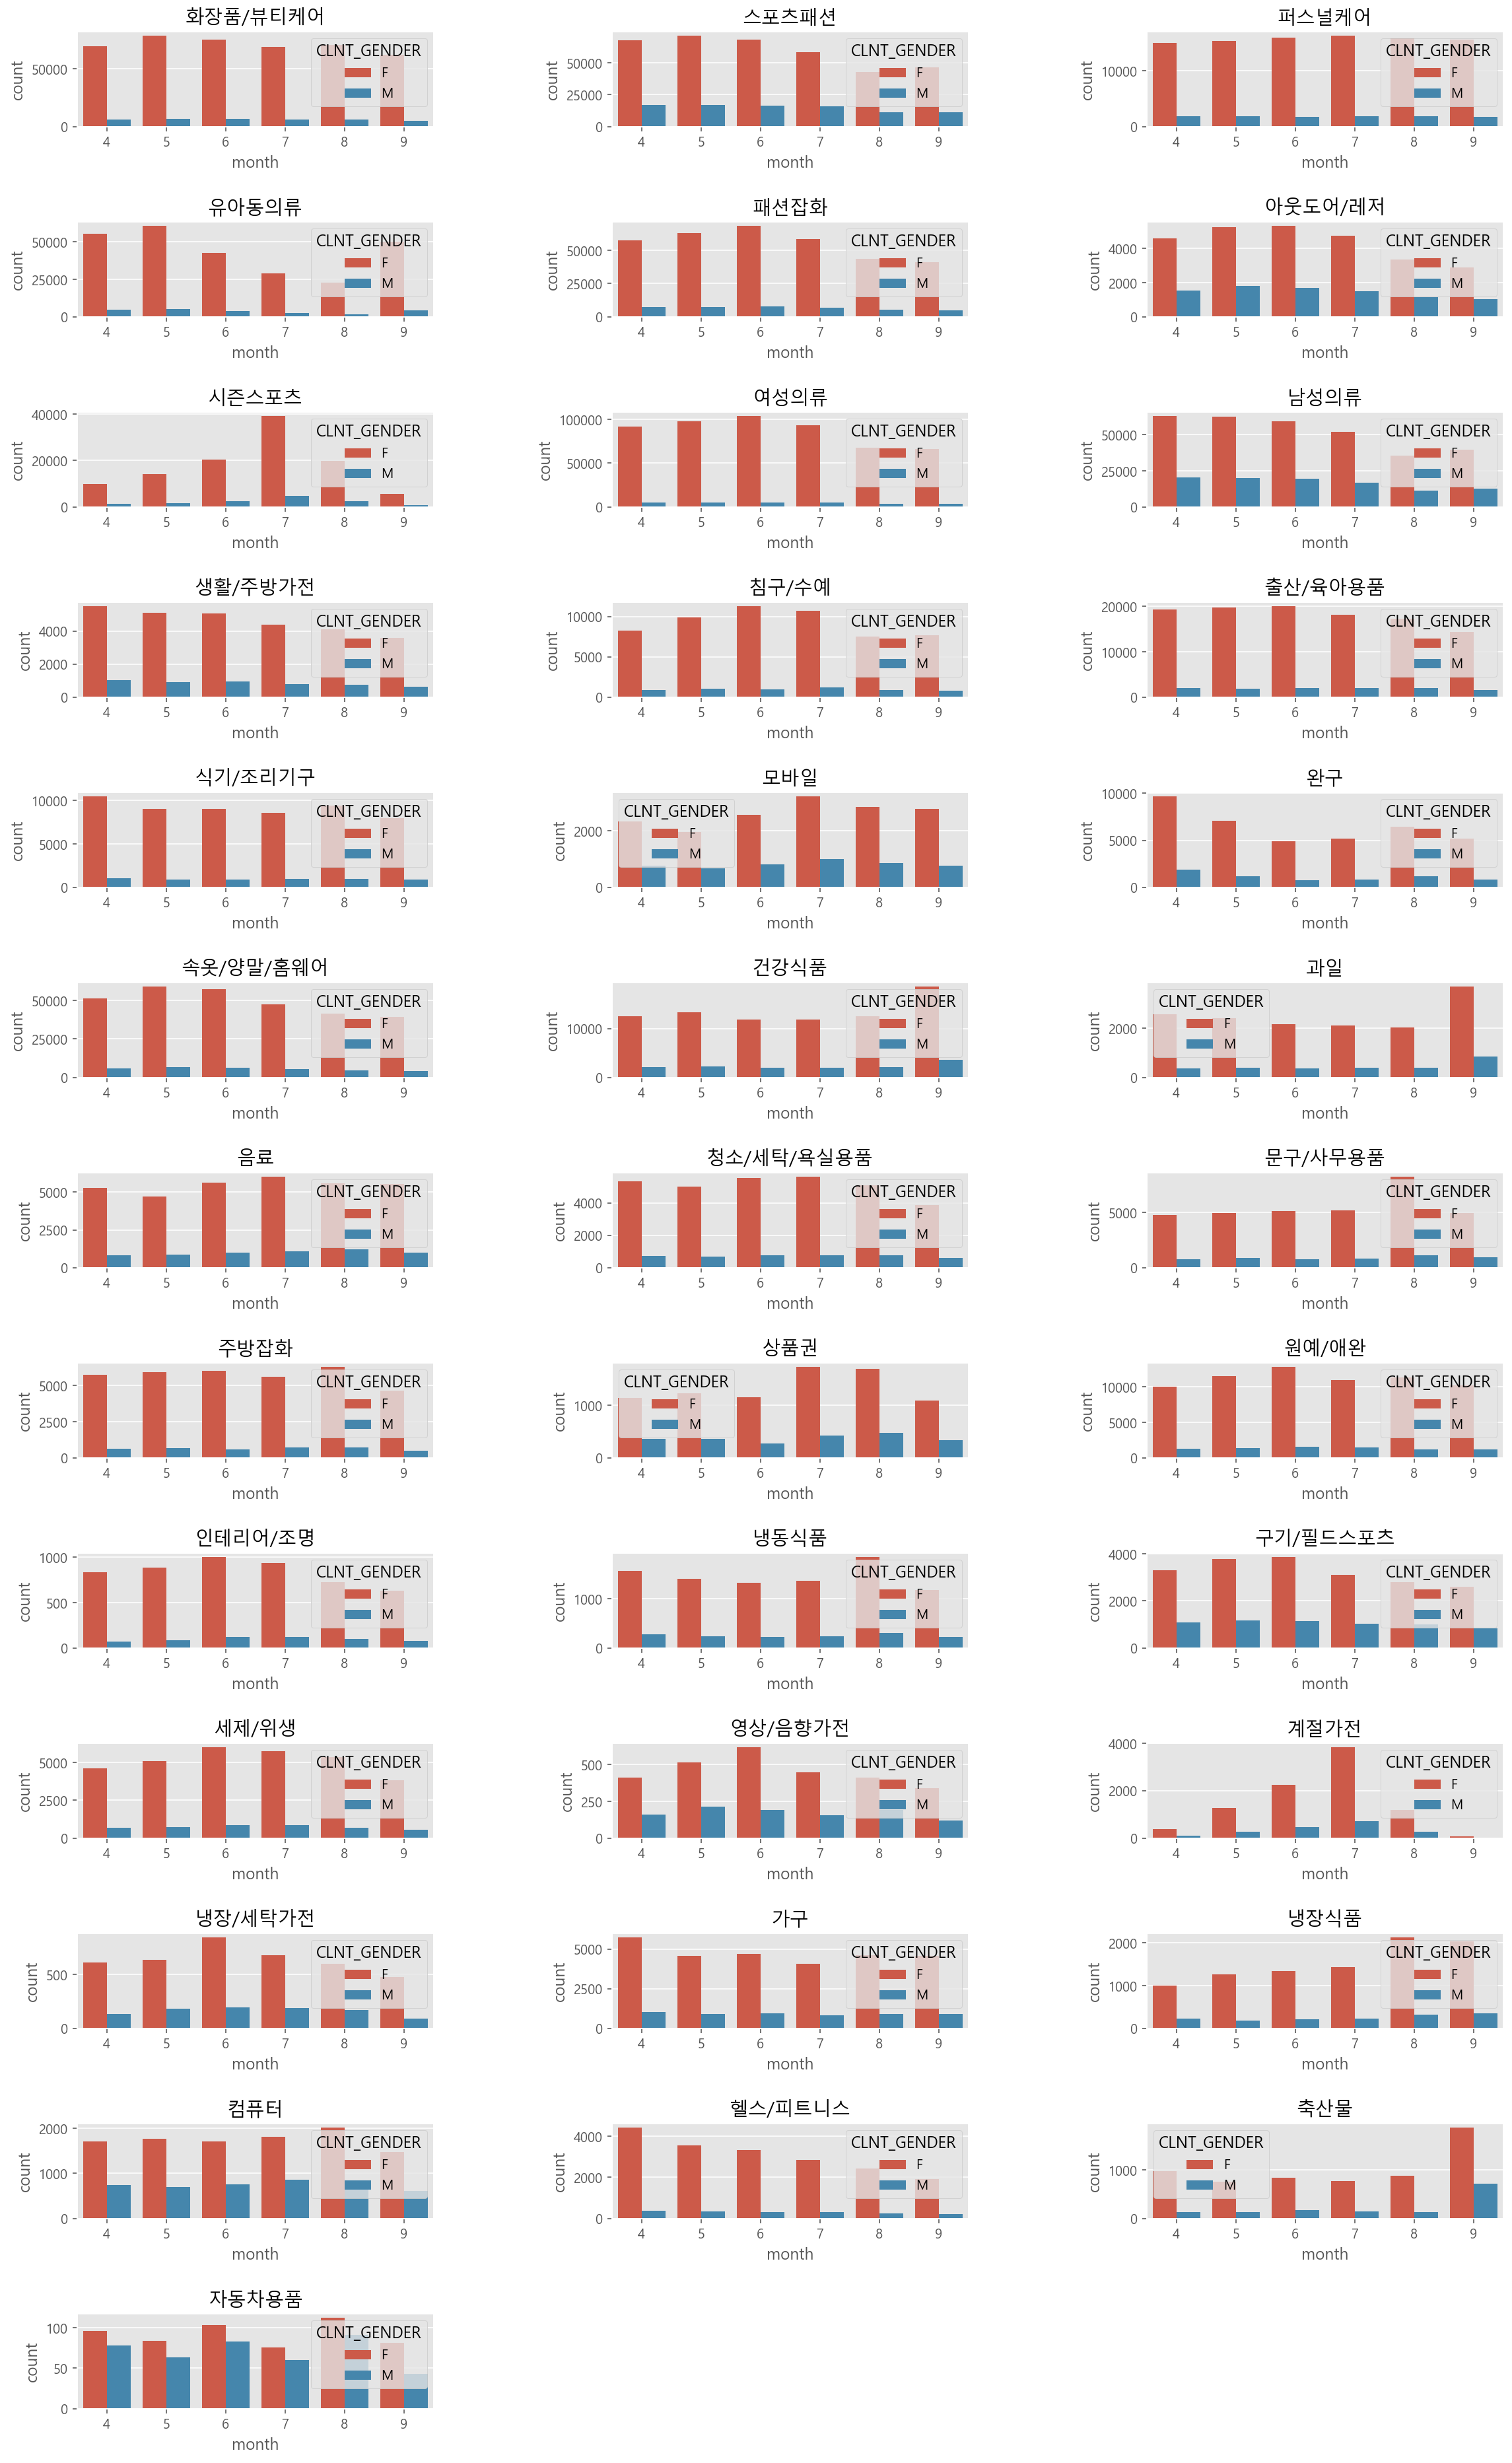

In [43]:
# 월별/성별별 cat1 별 판매 횟수
plt.figure(figsize=[15,25])
plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 1, wspace = 0.5)
cols = 3
rows = 13 

for i in range(1,38):
    
    plt.subplot(rows, cols, i)
    plt.title(cat[i-1])  
    df_cat=pscm[pscm['CLAC1_NM']==cat[i-1]]
    df_cat=df_cat.sort_values('CLNT_GENDER')
    sns.countplot(data=df_cat,x='month',hue='CLNT_GENDER')

plt.show()

성별이 구분되는 회원의 경우 애초에 여성비율이 높았기 때문에 대부분의 그래프에서 여성의 count가 많은 경향이 있다.

## ⅲ. 브랜드별

1. 판매 횟수

In [21]:
TOP100_BRAND=pscm.pivot_table(index='PD_BRA_NM',
                            values='PD_BUY_TOTAL',
                          aggfunc=['count','sum'])
TOP100_BRAND.head(10)

count          sum
            PD_BUY_TOTAL PD_BUY_TOTAL
PD_BRA_NM                            
#텐텐                  312    8499160.0
(유)자연식품               36    1028700.0
(주) 스마트 팩토리            2     105600.0
(주)그린키즈               12      28380.0
(주)다경                 72    3482300.0
(주)두문                 14     632500.0
(주)두잇                  8     395500.0
(주)로드메일코리아             2      91000.0
(주)비엘퓨리티              15    2580000.0
(주)참옻나라                1      45000.0

In [22]:
# 판매 횟수가 가장 많은 브랜드
TOP100cnt_BRAND=TOP100_BRAND['count'].sort_values(['PD_BUY_TOTAL'],ascending=False).head(100)
TOP100cnt_BRAND

PD_BUY_TOTAL
PD_BRA_NM                 
지오다노                 95245
나이키                  59161
탑텐                   41150
정관장                  40419
에이치커넥트               39977
크록스                  35548
아디다스(의류)             31265
입생로랑                 28805
첨이첨이                 26576
코데즈컴바인 이너웨어          24397
헤지스남성                24247
블루독                  23408
맥                    23279
엘르이너웨어               22661
나스                   22212
설화수                  20927
랩                    20344
디스커버리                20329
레노마키즈                19925
조르지오 아르마니            19752
바보사랑                 19273
난닝구                  18763
제이제이 지고트             18281
에고이스트                17683
노스페이스                17237
쉬즈미스                 16974
아디다스(슈즈)             16925
엠엘비키즈                16805
래핑차일드                16338
아디다스                 16322
헤라                   16015
행텐                   15752
나이키(슈즈)              15650
아이더                  15488
키엘                   15185
빈폴                   14375
더바디샵                 14164
폴햄                   14113
무냐무냐                 13781
빈폴아웃도어               13709
비너스 아르보              13638
블랙야크(키즈)             13575
랑콤                   13462
나이키(의류)              13443
디올                   13351
에스티 로더               13209
노스페이스키즈(아동)          13105
빈폴레이디스               12923
올삭스                  12902
레노마수영복               12862
뉴발란스(키즈)             12787
비오템                  12560
플라스틱아일랜드스토리          12408
아이오페                 12276
크리니크                 12233
아레나(수영복)             11738
이니스프리                11572
한샘                   11501
라코스테(의류)             11257
오가닉맘                 11239
해피프린스                11220
네파키즈                 11160
아트박스                 11142
페리미츠                 11118
핑크시슬리                11074
바비브라운                11001
지오지아                 10961
LG전자                 10853
빈                    10797
타미진                  10786
아디다스 오리지날            10770
에잇세컨즈                10710
써스데이아일랜드             10606
지지피엑스                10595
노스페이스영               10331
영실업                  10110
메이크업포에버              10096
케이스위스                10066
알로봇                  10052
버켄스탁                 10009
데상트                  10006
슈에무라                  9954
이앤씨                   9949
테이트                   9899
매그제이(MAGJAY)          9875
포트메리온                 9829
리스트                   9822
케이투                   9718
베네피트                  9646
플레이키즈프로               9611
엠폴햄                   9545
티비제이                  9541
정관장.                  9414
게스(진)                 9194
에블린                   9105
샤넬                    9067
보니알렉스                 9042
빌리프                   9036
타미힐피거여성               8980
에티튜드                  8979

Text(0.5, 1.0, '브랜드별 count')

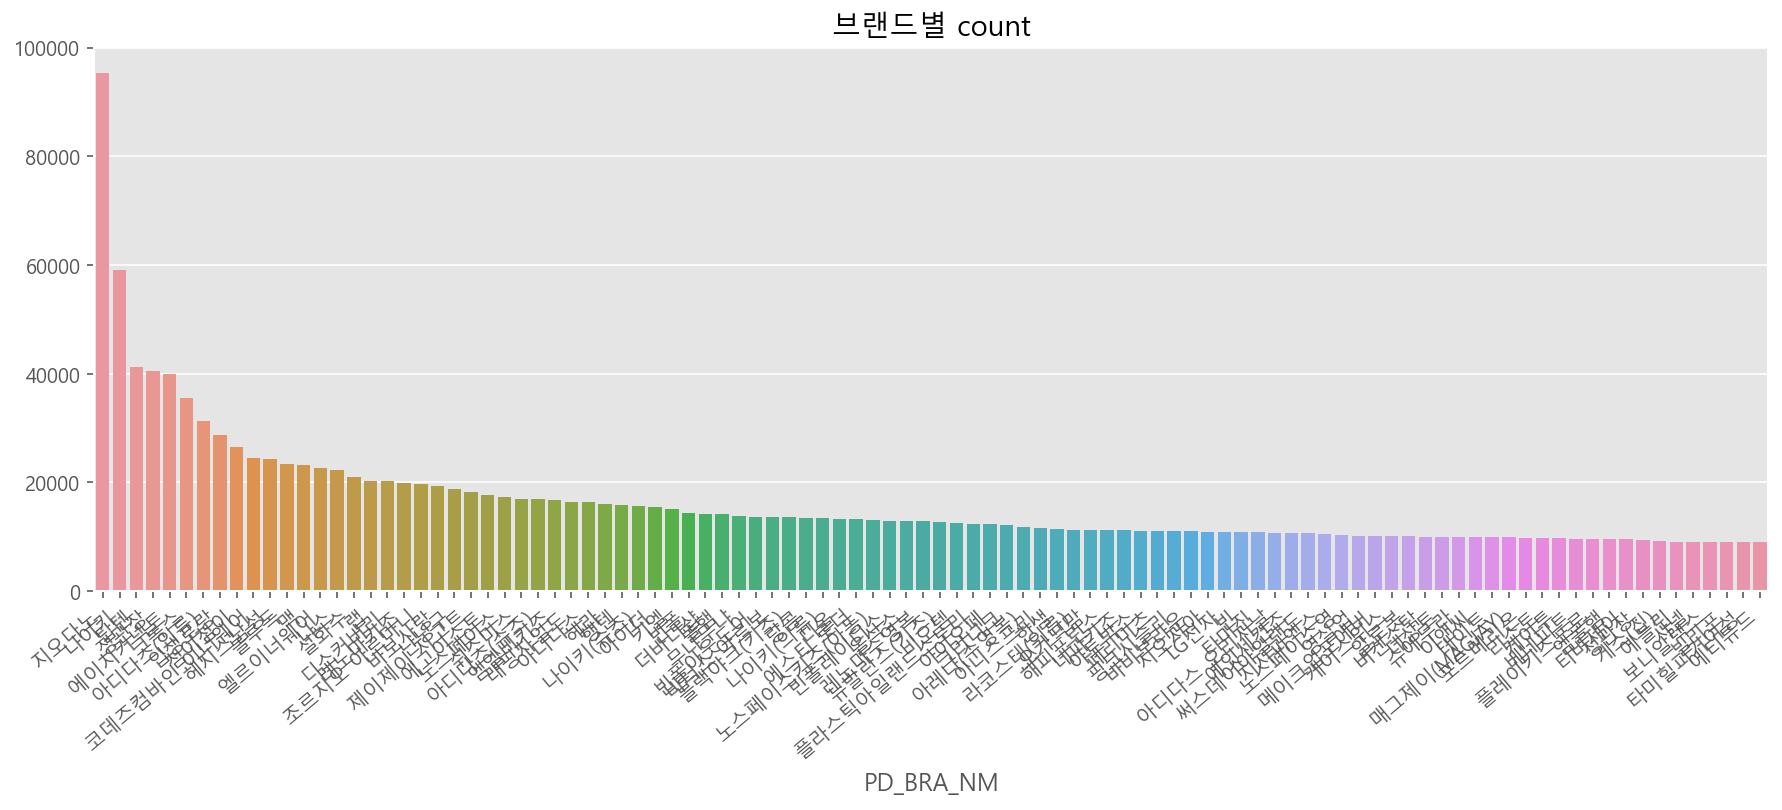

In [23]:
plt.figure(figsize=[15,5])
plt.xticks(rotation=40,ha='right')
sns.barplot(x=TOP100cnt_BRAND.index, y=np.ravel(TOP100cnt_BRAND.values,order='F'))
plt.title("브랜드별 count")

2. 금액별

In [24]:
# 판매 금액이 가장 많은 브랜드
pd.options.display.float_format = '{:.2f}'.format
TOP100sell_BRAND=TOP100_BRAND['sum'].sort_values(['PD_BUY_TOTAL'],ascending=False).head(100)
TOP100sell_BRAND

PD_BUY_TOTAL
PD_BRA_NM                  
LG전자         10392869332.00
정관장           6688340950.00
삼성전자          4199536934.00
나이키           4083078480.00
프라다           3480916739.00
설화수           3355647000.00
다이슨           2404368903.00
빈폴레이디스        2231592780.00
애플            2142059621.00
에고이스트         1804013100.00
한샘            1620524517.00
헤지스남성         1612532310.00
지오다노          1605245860.00
입생로랑          1536525200.00
SK-II         1484307000.00
빈폴            1384532420.00
디스커버리         1349085075.00
조르지오 아르마니     1275375000.00
구찌            1272063330.00
크록스           1183305280.00
나이키(슈즈)       1164421860.00
아디다스(의류)      1115694780.00
랑콤            1093148500.00
에몬스홈          1092984499.00
써스데이아일랜드      1087068580.00
라코스테(의류)      1083645750.00
나스            1080281000.00
에스티 로더        1054712000.00
노스페이스         1041869780.00
오야니(가방)        999746070.00
캐논             980003916.00
키엘             921552000.00
빈폴아웃도어         917145520.00
헤라             891794000.00
정관장.           891595870.00
닥스ACC          886375430.00
블루독            878966080.00
데상트            872230290.00
타미힐피거여성        858345480.00
맥              854646000.00
제이제이 지고트       848349670.00
아디다스(슈즈)       847746640.00
골든구스           840929050.00
위닉스            820934398.00
디올             818412000.00
비오템            818089600.00
엠엘비키즈          811059260.00
핏플랍            782408950.00
샤넬             775153780.00
아이더            762832000.00
아디다스           759320580.00
위니아            755807308.00
헤지스 레이디스       746399080.00
타미진            730015330.00
에이스침대          710772011.00
랩              702581400.00
나이스클랍          701437830.00
쉬즈미스           699921740.00
타미힐피거          673441780.00
케이투            667406453.00
오야니            664193600.00
지방시            657474786.00
빈폴ACC          649374580.00
필립스(PHILIPS)   640362080.00
뉴발란스(키즈)       629656900.00
포트메리온          610422060.00
노스페이스키즈(아동)    608037150.00
버켄스탁           605956800.00
바비브라운          603774350.00
버버리            598404326.00
나이키(의류)        590645680.00
블랙야크(키즈)       569734250.00
노스페이스영         561141610.00
아이오페           559064500.00
크리니크           555172000.00
헤지스레이디스        551270680.00
코오롱스포츠         532736800.00
토리버치           525945280.00
디자인벤처스         523770185.00
소니             518868926.00
쿠쿠             517379132.00
시몬스            512187760.00
탑텐             511042240.00
레노마수영복         508322850.00
메트로시티          499620320.00
보브(의류)         491853170.00
발렌티노           490625229.00
플라스틱아일랜드스토리    484676120.00
아디다스 오리지널      484171180.00
메이크업포에버        475030000.00
아디다스 오리지날      471788770.00
엘지프라엘          467099634.00
올리브데올리브        466048640.00
슈에무라           458567000.00
네파키즈           457083370.00
쿠론             451945200.00
에이치커넥트         450014900.00
씨씨콜렉트          450006300.00
쥬크             449096960.00
헤지스골프          434208300.00

Text(0.5, 1.0, '브랜드별 판매액')

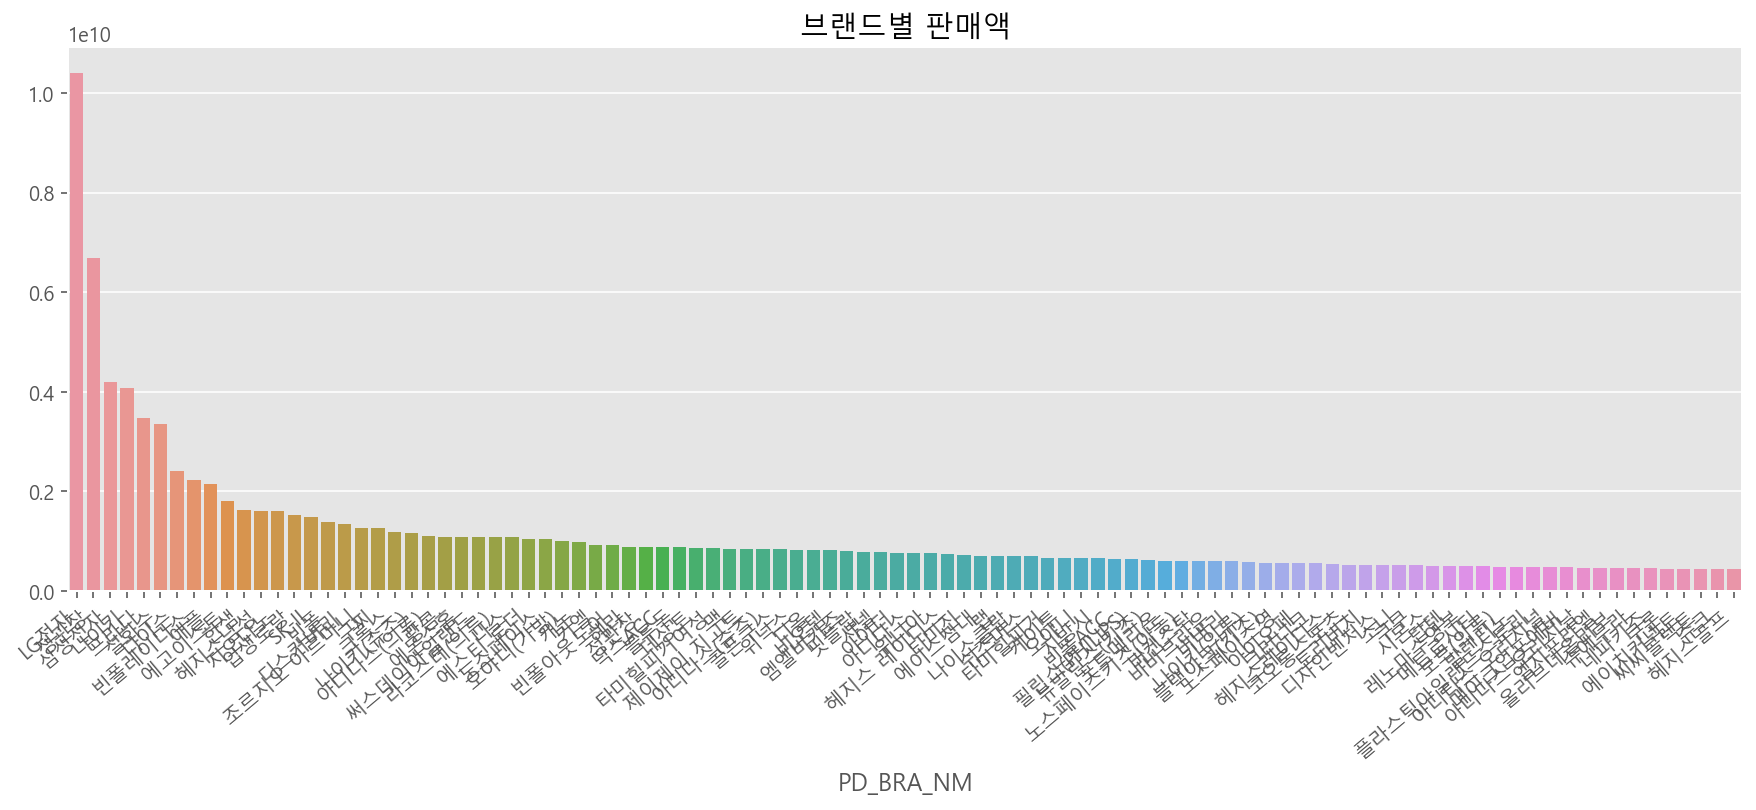

In [25]:
plt.figure(figsize=[15,5])
plt.xticks(rotation=40,ha='right')
sns.barplot(x=TOP100sell_BRAND.index, y=np.ravel(TOP100sell_BRAND.values,order='F'))
plt.title("브랜드별 판매액")

# ⅳ. 카테고리별

1. 횟수별

In [26]:
pd.options.display.float_format = '{:.2f}'.format
TOP100_CAT1=pscm.pivot_table(index='CLAC1_NM',
                            values='PD_BUY_TOTAL',
                          aggfunc=['count','sum'])
TOP100_CAT1.head(10)

count            sum
         PD_BUY_TOTAL   PD_BUY_TOTAL
CLAC1_NM                            
가구              43217 12327868105.00
건강식품           122972 10716807066.00
계절가전            13829  5215936866.00
과일              25007   788448960.00
구기/필드스포츠        33777  2487345657.00
남성의류           552787 18390274665.00
냉동식품            13526   302180730.00
냉장/세탁가전          7496  7388963322.00
냉장식품            13751   428534860.00
모바일             25924  1577778123.00

In [27]:
# 판매 횟수가 가장 많은 CAT1
TOP100cnt_CAT1=TOP100_CAT1['count'].sort_values(['PD_BUY_TOTAL'],ascending=False).head(100)
TOP100cnt_CAT1.head(10)

PD_BUY_TOTAL
CLAC1_NM               
여성의류             675325
화장품/뷰티케어         571721
스포츠패션            562048
남성의류             552787
패션잡화             447115
속옷/양말/홈웨어        415942
유아동의류            340414
시즌스포츠            149733
출산/육아용품          140643
퍼스널케어            132365

Text(0.5, 1.0, 'cat1별 count')

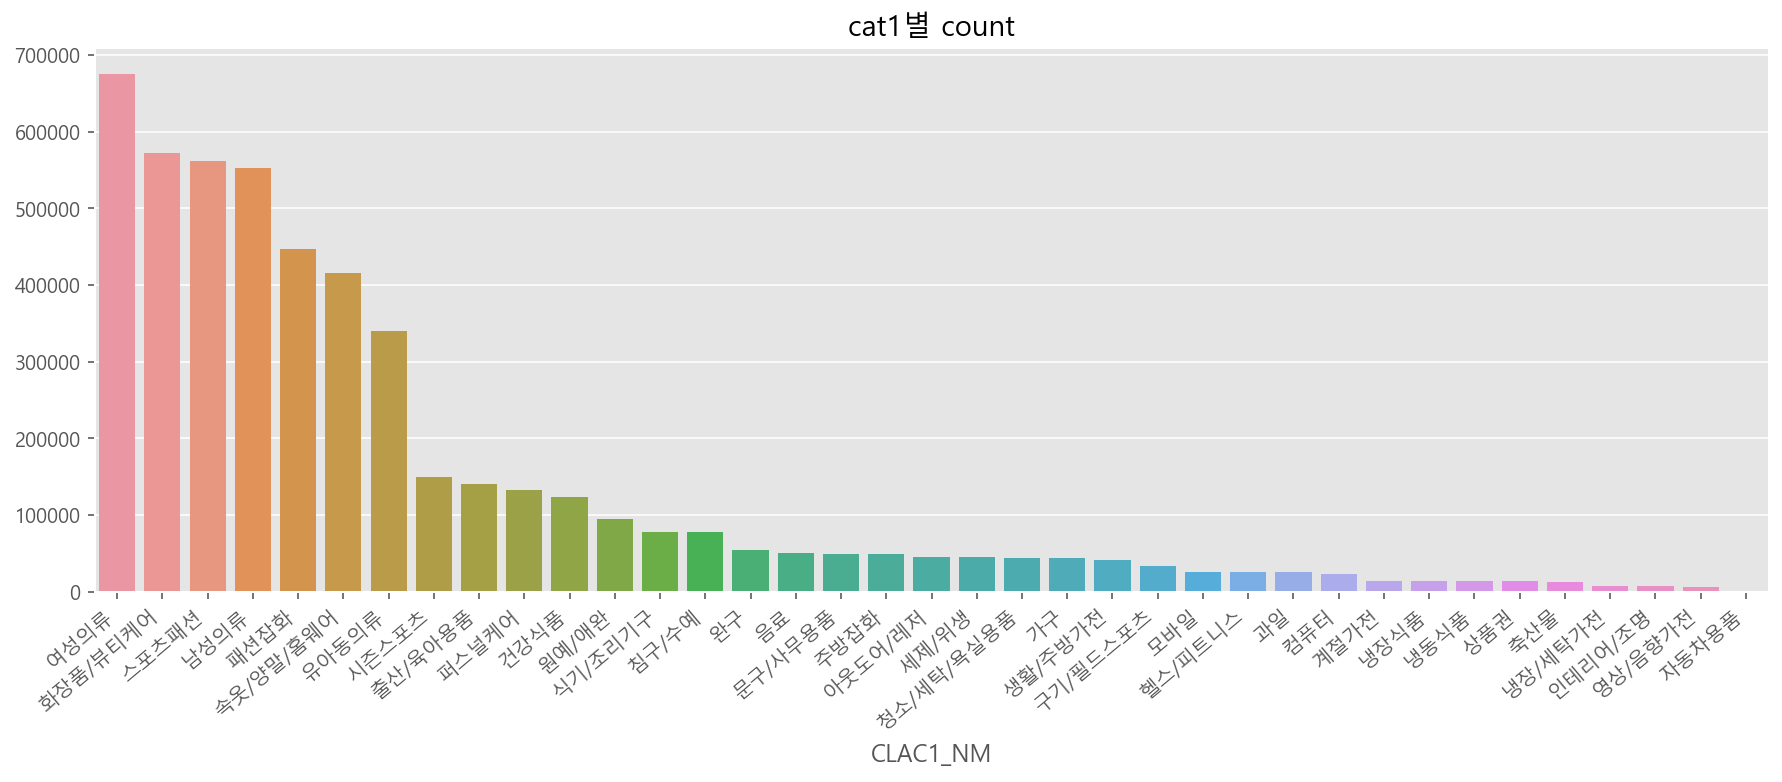

In [28]:
plt.figure(figsize=[15,5])
plt.xticks(rotation=40,ha='right')
sns.barplot(x=TOP100cnt_CAT1.index, y=np.ravel(TOP100cnt_CAT1.values,order='F'))
plt.title("cat1별 count")

2. 금액별

In [29]:
# 판매 금액이 가장 많은 CAT1
pd.options.display.float_format = '{:.2f}'.format
TOP100sell_CAT1=TOP100_BRAND['sum'].sort_values(['PD_BUY_TOTAL'],ascending=False).head(100)
TOP100sell_CAT1

PD_BUY_TOTAL
PD_BRA_NM                  
LG전자         10392869332.00
정관장           6688340950.00
삼성전자          4199536934.00
나이키           4083078480.00
프라다           3480916739.00
설화수           3355647000.00
다이슨           2404368903.00
빈폴레이디스        2231592780.00
애플            2142059621.00
에고이스트         1804013100.00
한샘            1620524517.00
헤지스남성         1612532310.00
지오다노          1605245860.00
입생로랑          1536525200.00
SK-II         1484307000.00
빈폴            1384532420.00
디스커버리         1349085075.00
조르지오 아르마니     1275375000.00
구찌            1272063330.00
크록스           1183305280.00
나이키(슈즈)       1164421860.00
아디다스(의류)      1115694780.00
랑콤            1093148500.00
에몬스홈          1092984499.00
써스데이아일랜드      1087068580.00
라코스테(의류)      1083645750.00
나스            1080281000.00
에스티 로더        1054712000.00
노스페이스         1041869780.00
오야니(가방)        999746070.00
캐논             980003916.00
키엘             921552000.00
빈폴아웃도어         917145520.00
헤라             891794000.00
정관장.           891595870.00
닥스ACC          886375430.00
블루독            878966080.00
데상트            872230290.00
타미힐피거여성        858345480.00
맥              854646000.00
제이제이 지고트       848349670.00
아디다스(슈즈)       847746640.00
골든구스           840929050.00
위닉스            820934398.00
디올             818412000.00
비오템            818089600.00
엠엘비키즈          811059260.00
핏플랍            782408950.00
샤넬             775153780.00
아이더            762832000.00
아디다스           759320580.00
위니아            755807308.00
헤지스 레이디스       746399080.00
타미진            730015330.00
에이스침대          710772011.00
랩              702581400.00
나이스클랍          701437830.00
쉬즈미스           699921740.00
타미힐피거          673441780.00
케이투            667406453.00
오야니            664193600.00
지방시            657474786.00
빈폴ACC          649374580.00
필립스(PHILIPS)   640362080.00
뉴발란스(키즈)       629656900.00
포트메리온          610422060.00
노스페이스키즈(아동)    608037150.00
버켄스탁           605956800.00
바비브라운          603774350.00
버버리            598404326.00
나이키(의류)        590645680.00
블랙야크(키즈)       569734250.00
노스페이스영         561141610.00
아이오페           559064500.00
크리니크           555172000.00
헤지스레이디스        551270680.00
코오롱스포츠         532736800.00
토리버치           525945280.00
디자인벤처스         523770185.00
소니             518868926.00
쿠쿠             517379132.00
시몬스            512187760.00
탑텐             511042240.00
레노마수영복         508322850.00
메트로시티          499620320.00
보브(의류)         491853170.00
발렌티노           490625229.00
플라스틱아일랜드스토리    484676120.00
아디다스 오리지널      484171180.00
메이크업포에버        475030000.00
아디다스 오리지날      471788770.00
엘지프라엘          467099634.00
올리브데올리브        466048640.00
슈에무라           458567000.00
네파키즈           457083370.00
쿠론             451945200.00
에이치커넥트         450014900.00
씨씨콜렉트          450006300.00
쥬크             449096960.00
헤지스골프          434208300.00

Text(0.5, 1.0, 'cat1별 판매금액')

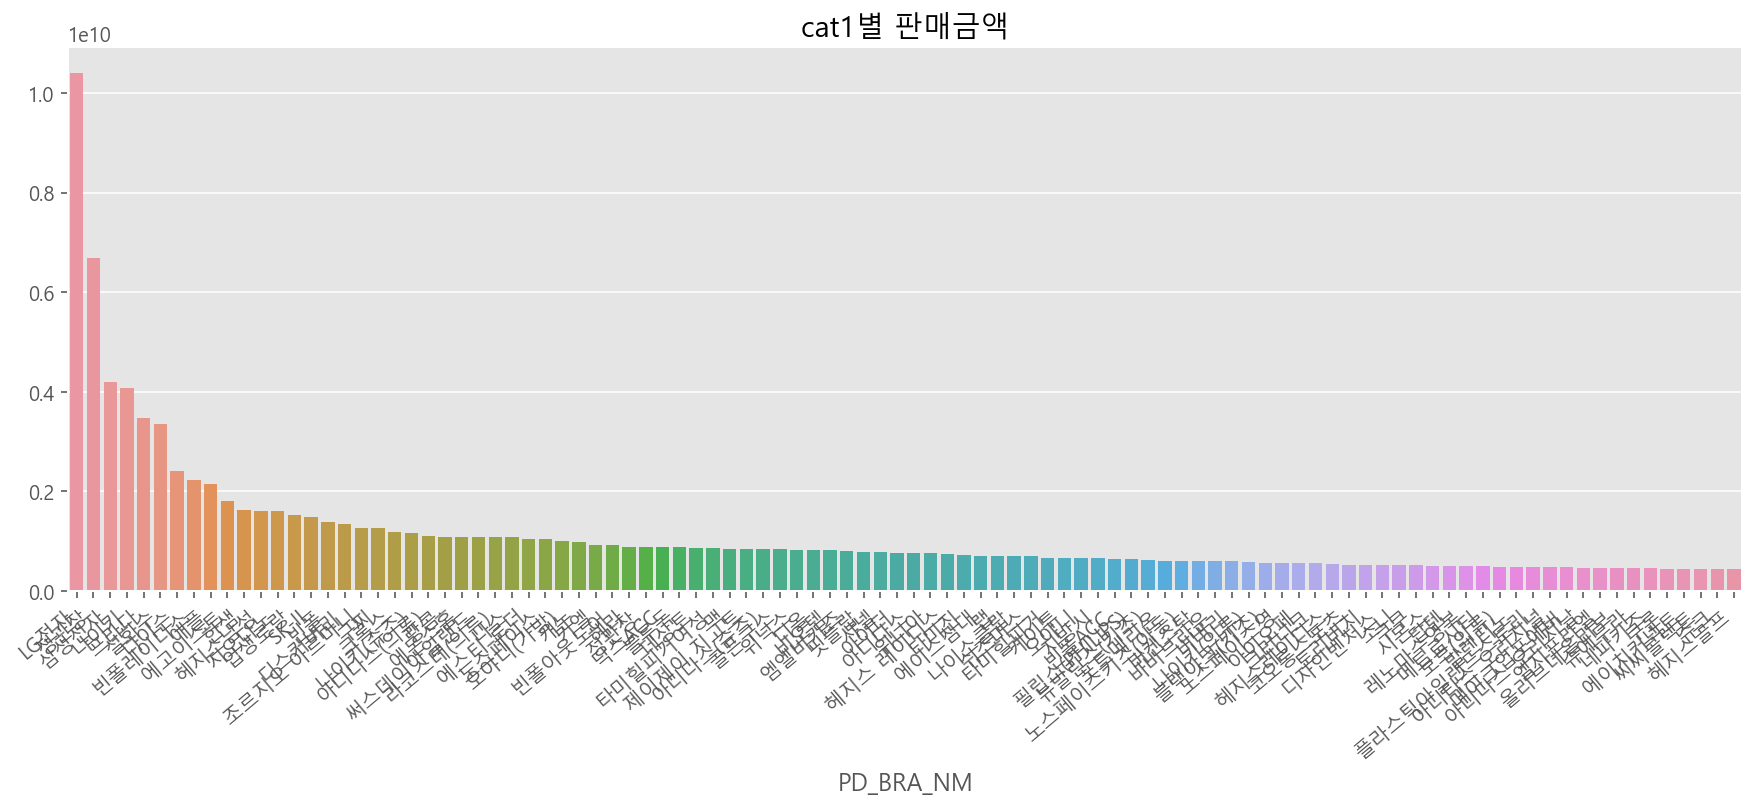

In [30]:
plt.figure(figsize=[15,5])
plt.xticks(rotation=40,ha='right')
sns.barplot(x=TOP100sell_CAT1.index, y=np.ravel(TOP100sell_CAT1.values,order='F'))
plt.title("cat1별 판매금액")

# Ⅱ. 제품 탐색 및 구매 시각

In [31]:
day_count=pscm.groupby(['CLAC1_NM','COUNT_DAY'])['PD_BUY_CT'].agg({'count':sum}).reset_index()

C:\Users\meuch\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  """Entry point for launching an IPython kernel.


In [32]:
day_count.head(17)

CLAC1_NM  COUNT_DAY  count
0        가구     736785    525
1        가구     736786    560
2        가구     736787    424
3        가구     736788    471
4        가구     736789    349
5        가구     736790    341
6        가구     736791    330
7        가구     736792    395
8        가구     736793    531
9        가구     736794    384
10       가구     736795    358
11       가구     736796    328
12       가구     736797    300
13       가구     736798    216
14       가구     736799    315
15       가구     736800    443
16       가구     736801    384

In [33]:
# 해당 자료 기간 y년m월1일을 생성하고 days로 환산해준다. (아래 파란선을 그리기 위함)
yearmonth_list=pd.date_range(min(pscm['SESS_DT']),max(pscm['SESS_DT']), freq='MS').tolist()

In [34]:
count_day1=[i.toordinal() for i in yearmonth_list]
count_day1

[736785, 736815, 736846, 736876, 736907, 736938]

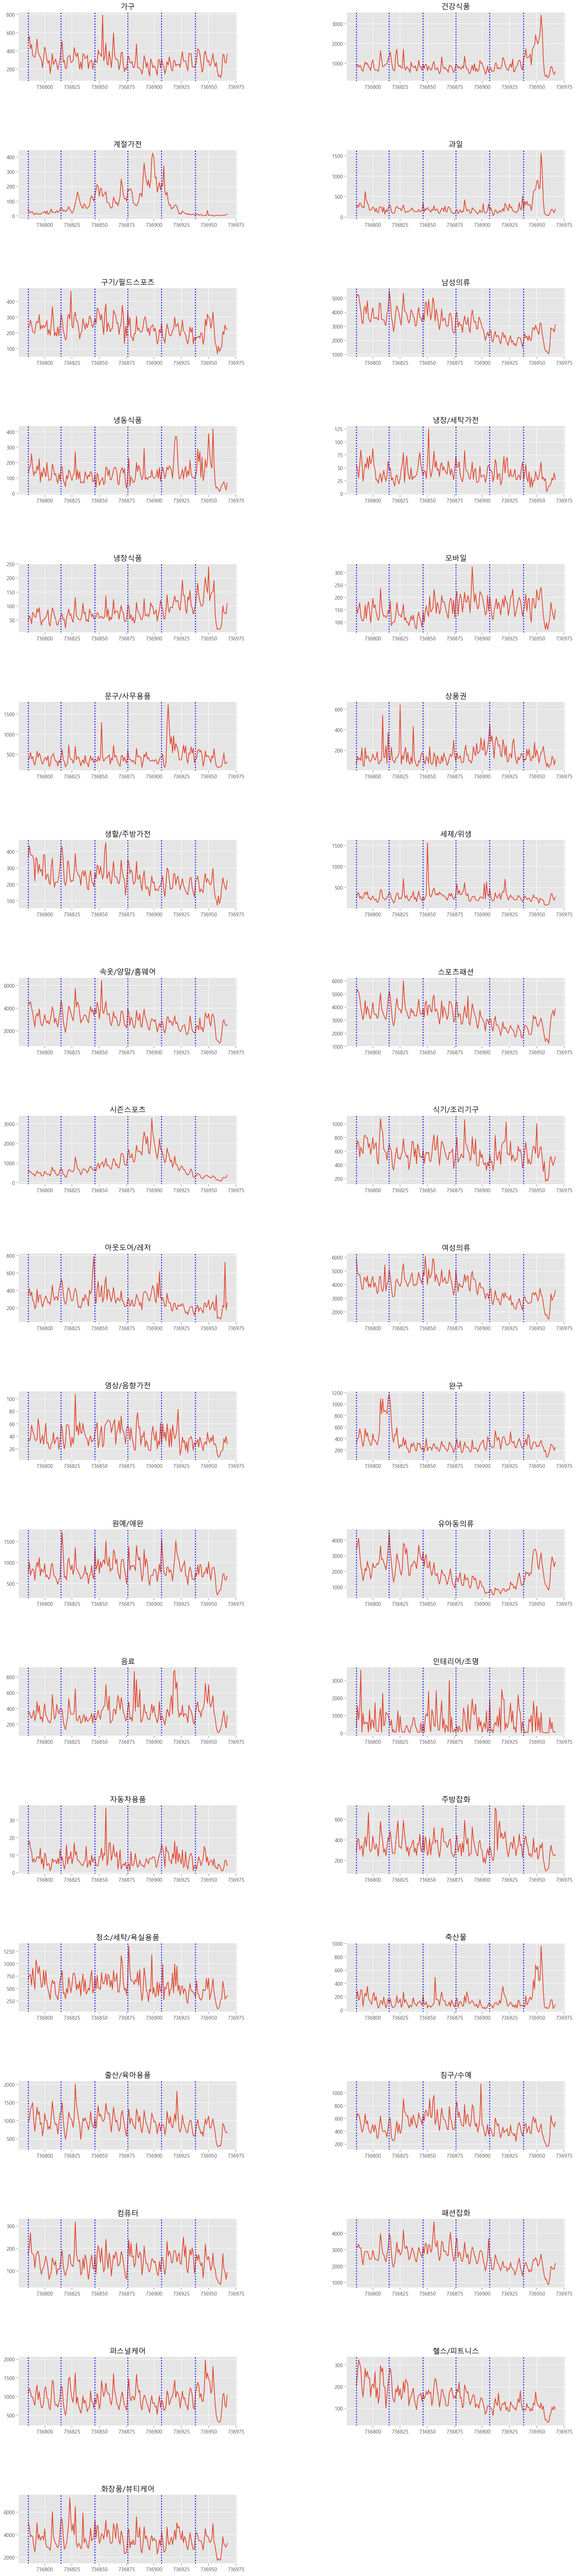

In [35]:
plt.figure(figsize=(15,70))
plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 1, wspace = 0.5)
cols = 2
rows = 19 

for i in range(1,38):
    
    data=day_count[day_count['CLAC1_NM']==day_count['CLAC1_NM'].unique()[i-1]]
    
    plt.subplot(rows, cols, i)
    
    plt.plot(data['COUNT_DAY'],data['count'])
    
    plt.title(day_count['CLAC1_NM'].unique()[i-1])
    for j in count_day1:
        plt.axvline(x=j, color='b', linestyle=':', linewidth=2)
    
    
plt.show()
    

한번씩 급격하게 변동하는 날이 관측된다.
이럴 경우 계절,sns, 연예인, 기사 등에 따라 다를 수도 있다.

# Ⅲ. VIP 선별

##  ⅰ.구매 금액별

In [ ]:
pd.options.display.float_format = '{:.0f}'.format
g=pscm.groupby(['CLAC1_NM','CLNT_GENDER','CLNT_ID'])['PD_BUY_TOTAL'].sum()
result = g.groupby(level=[0,1]).nlargest(5)
result=pd.DataFrame({'CLAC1_NM':list(list(zip(*result.index))[0]),
              'CLNT_GENDER':list(list(zip(*result.index))[1]),
              'CLNT_ID':list(list(zip(*result.index))[4]),
              'SUM_BUY':result.values
             })
result.head(17)

In [ ]:
plt.figure(figsize=(18,10))
plt.xticks(rotation=40,ha='right')
sns.boxplot(data=result,x='CLAC1_NM',y='SUM_BUY')
plt.title("카테고리별 구매 금액 top5")

In [ ]:
plt.figure(figsize=(18,10))
plt.xticks(rotation=40,ha='right')
sns.boxplot(data=result,x='CLAC1_NM',y='SUM_BUY',hue='CLNT_GENDER')
plt.title("카테고리별 구매 금액 top5")

In [ ]:
del g
del result

## ⅱ. 구매 횟수별(상품수량 고려x)

In [36]:
g=pscm.groupby(['CLAC1_NM','CLNT_GENDER'])['CLNT_ID'].value_counts()
result = pd.DataFrame(g.groupby(level=[0,1]).nlargest(5))
result=pd.DataFrame({'CLAC1_NM':list(list(zip(*result.index))[0]),
              'CLNT_GENDER':list(list(zip(*result.index))[1]),
              'CLNT_ID':list(list(zip(*result.index))[4]),
              'COUNT':list(list(zip(*result.values))[0])
             })
result.head(17)

CLAC1_NM CLNT_GENDER  CLNT_ID  COUNT
0        가구           F  5448721     57
1        가구           F  3413272     24
2        가구           F  5205560     24
3        가구           F  1333834     21
4        가구           F  4885627     19
5        가구           M  3137116    116
6        가구           M  5909621     24
7        가구           M   244731     16
8        가구           M  3276633     14
9        가구           M  4796733     13
10     건강식품           F  1616624    576
11     건강식품           F  5909567    166
12     건강식품           F  5592753     66
13     건강식품           F  1331360     44
14     건강식품           F   235570     38
15     건강식품           M  1662720    244
16     건강식품           M  1141526    111

Text(0.5, 1.0, '카테고리별 구매횟수 top5')

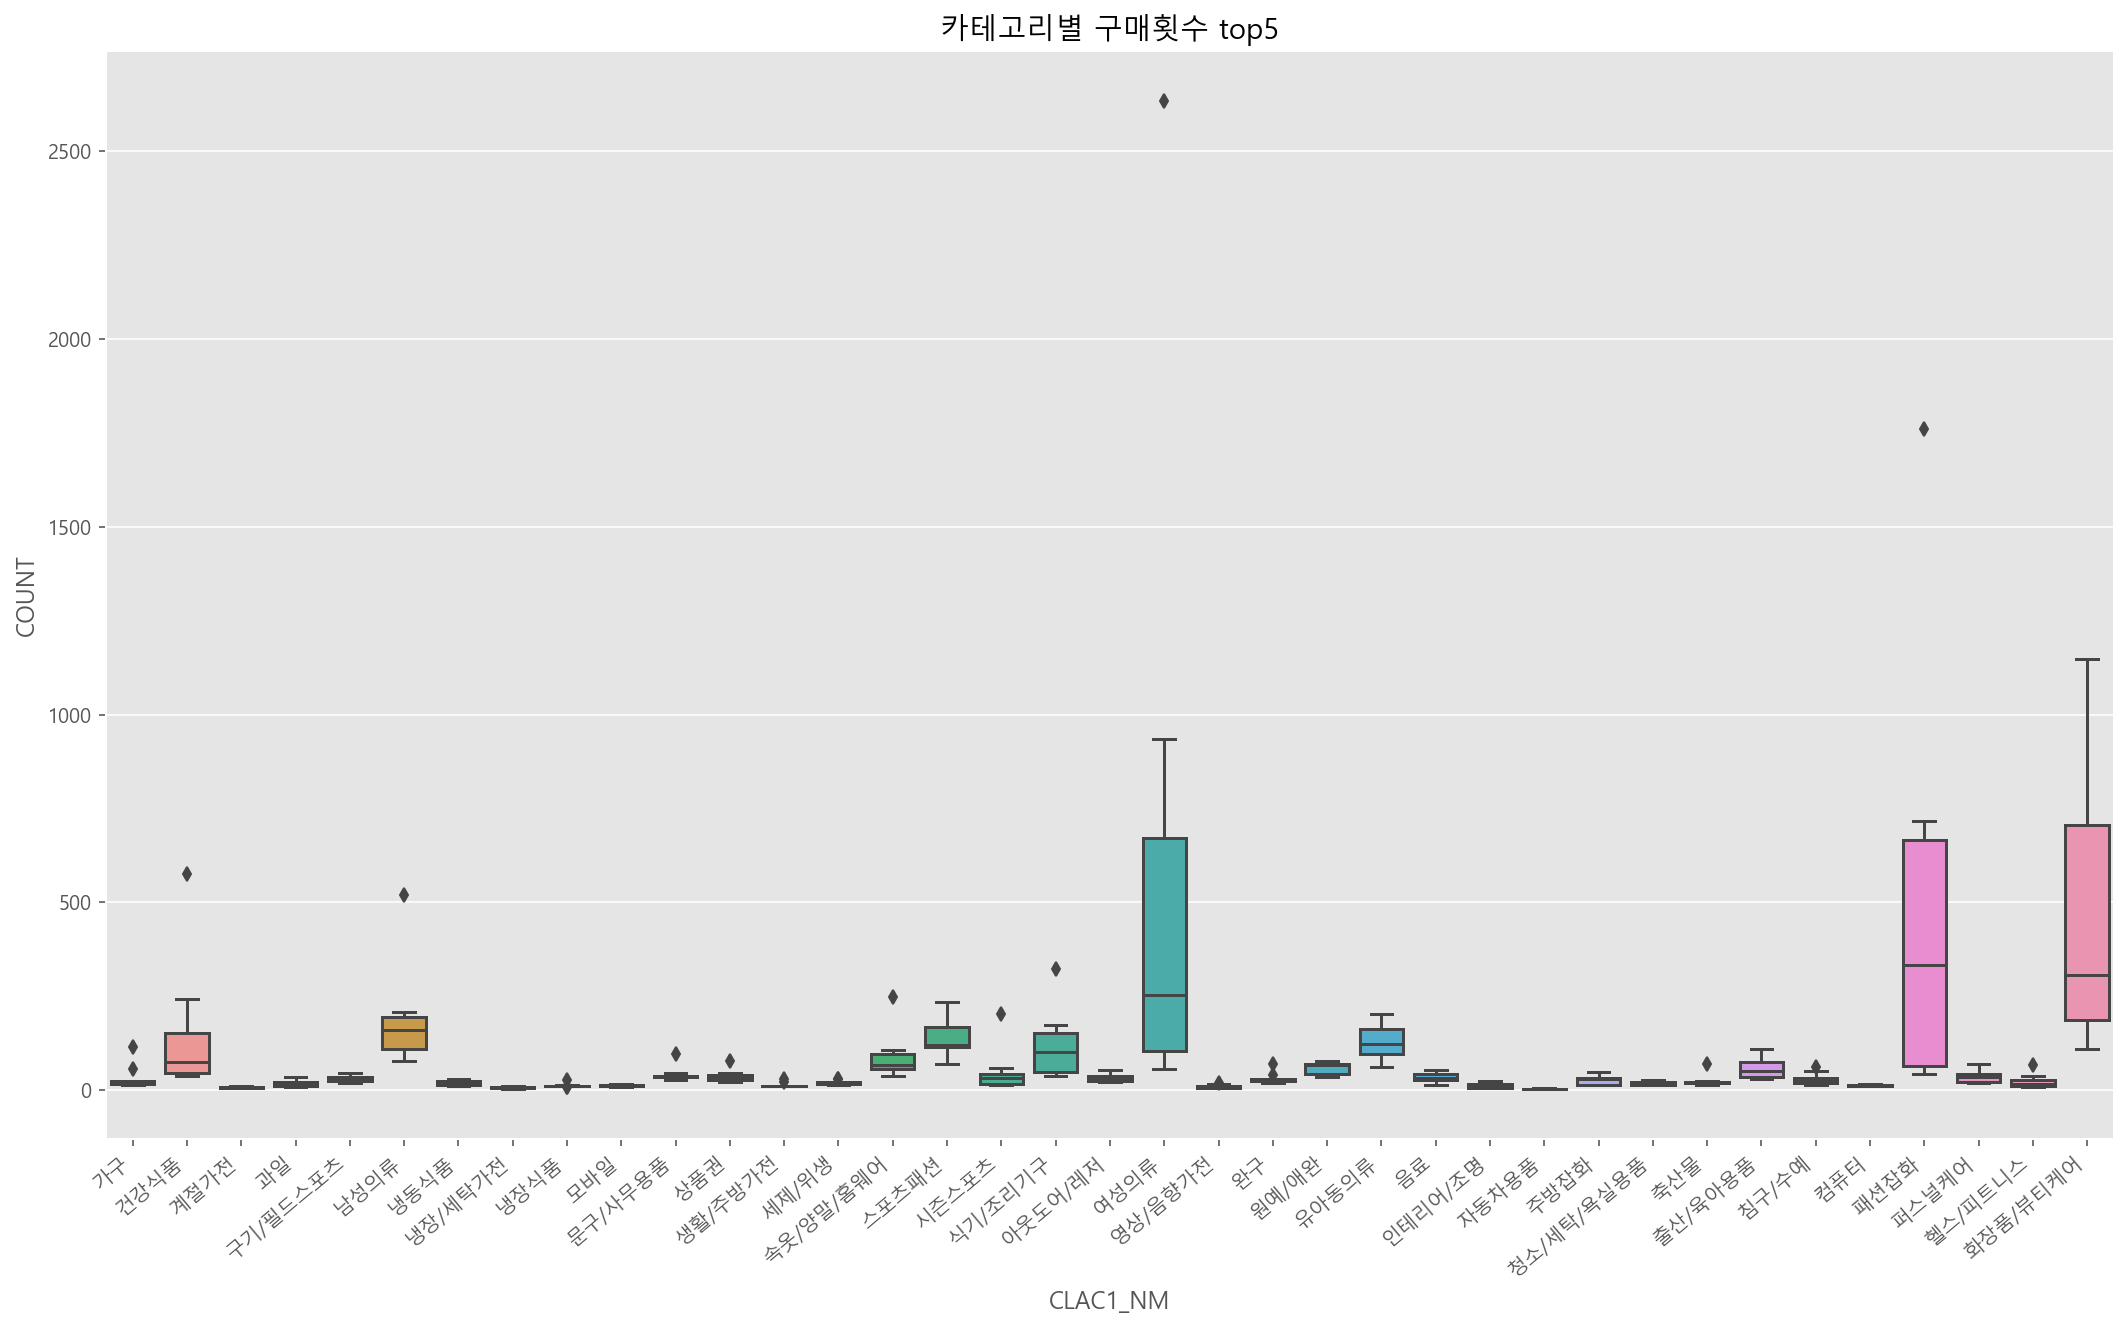

In [37]:
plt.figure(figsize=(18,10))
plt.xticks(rotation=40,ha='right')
sns.boxplot(data=result,x='CLAC1_NM',y='COUNT')
plt.title("카테고리별 구매횟수 top5")

Text(0.5, 1.0, '남/여 카테고리별 구매횟수 top5')

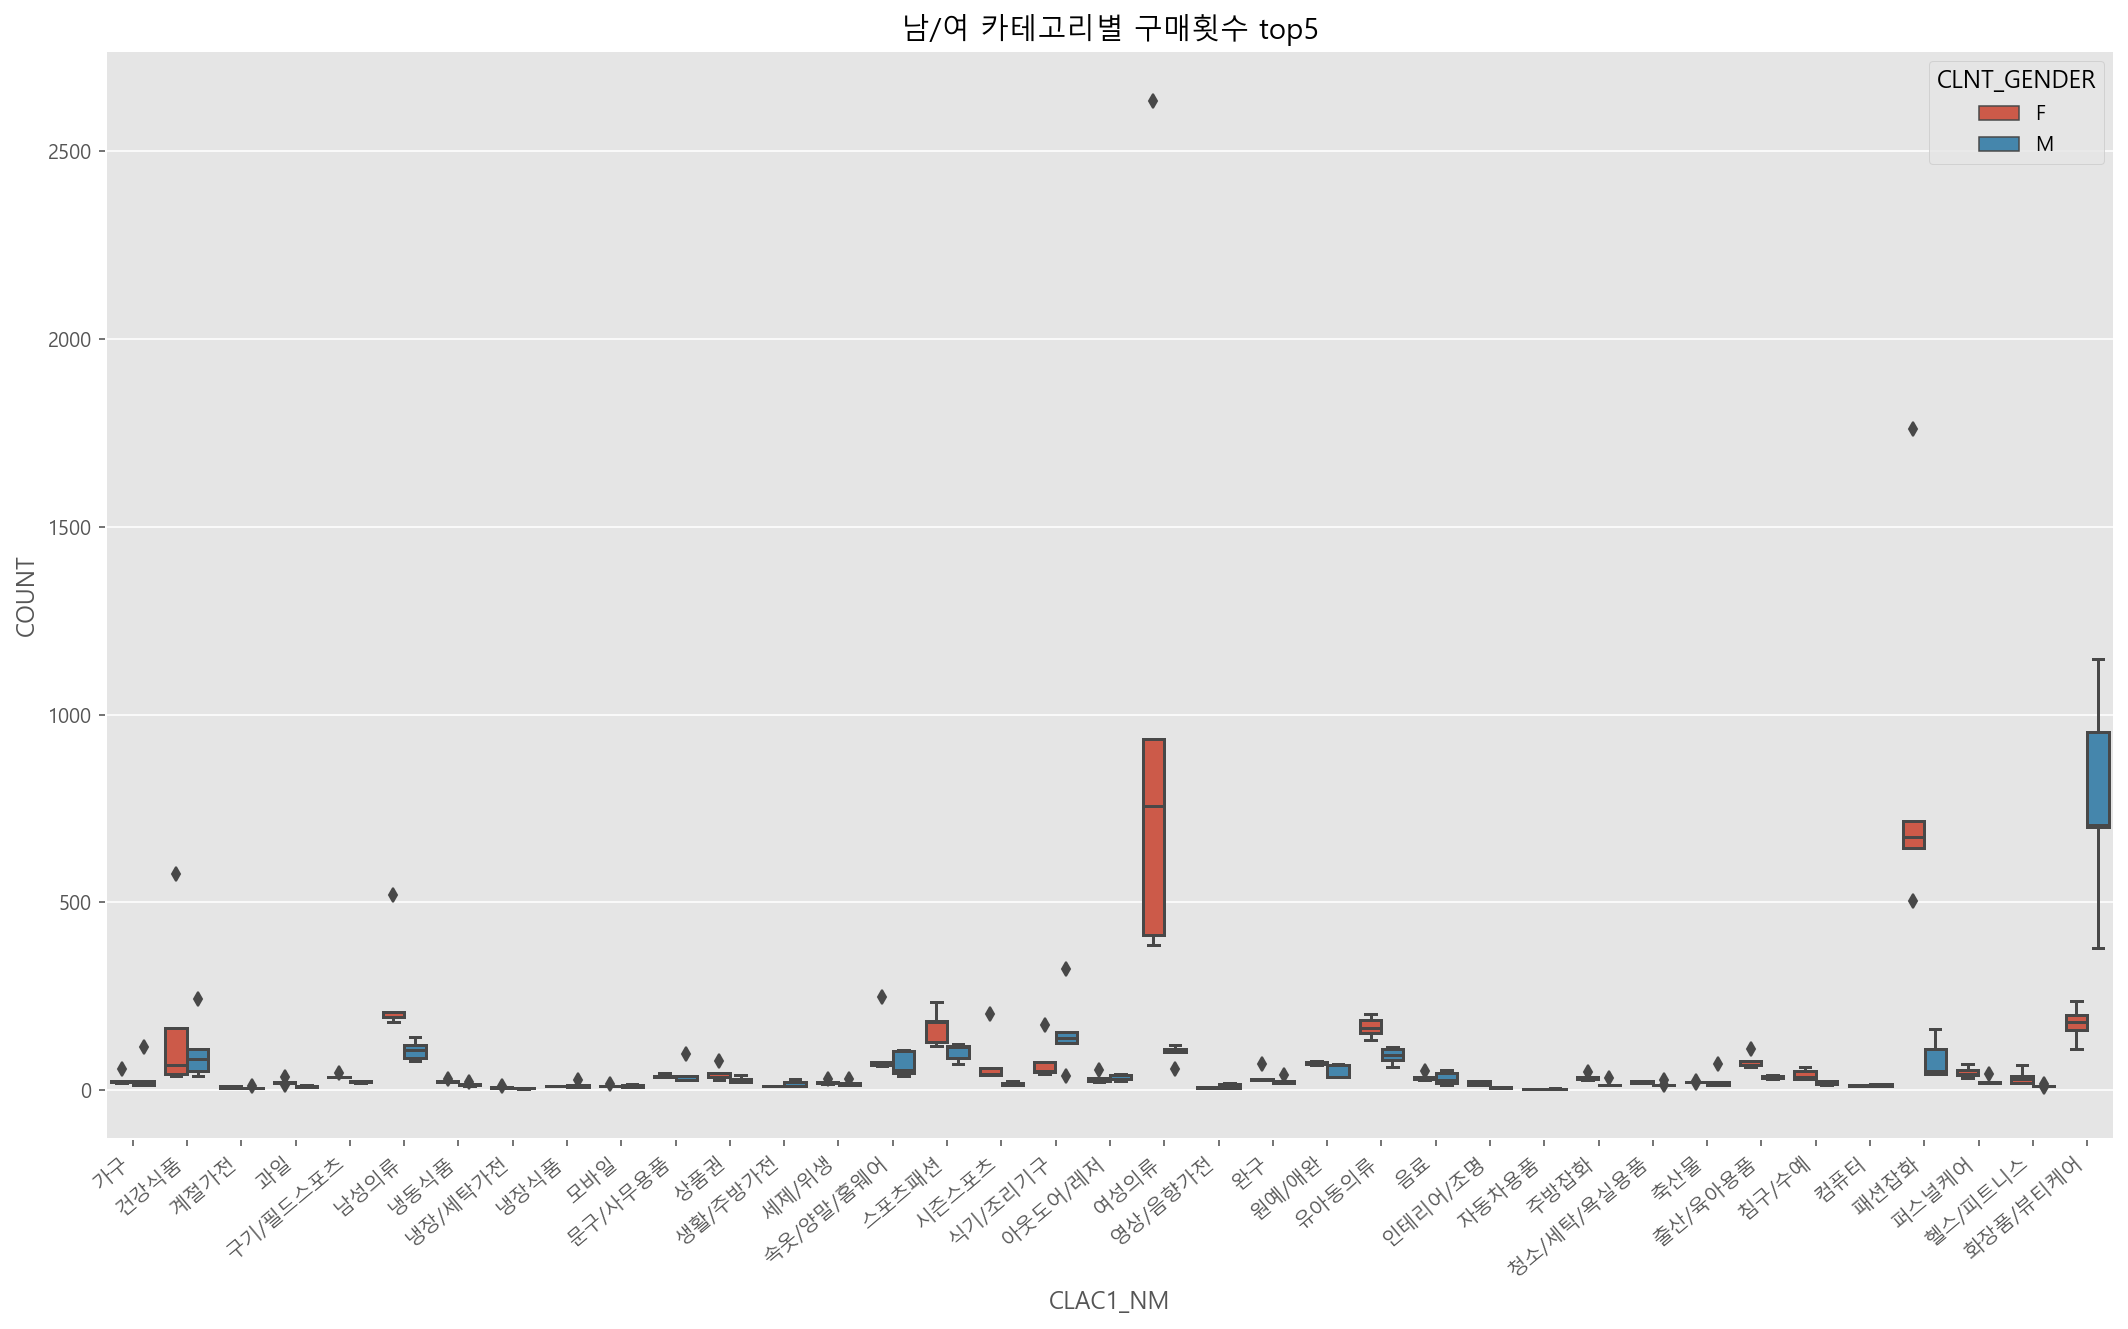

In [38]:
plt.figure(figsize=(18,10))
plt.xticks(rotation=40,ha='right')
sns.boxplot(data=result,x='CLAC1_NM',y='COUNT',hue='CLNT_GENDER')
plt.title("남/여 카테고리별 구매횟수 top5")

## ⅲ. 구매 횟수별(상품수량 고려o)


In [39]:
g=pscm.groupby(['CLAC1_NM','CLNT_GENDER','CLNT_ID'])['PD_BUY_CT'].sum()
g=g.reset_index()

In [40]:
result=pd.DataFrame(g.groupby(['CLAC1_NM','CLNT_GENDER'])['PD_BUY_CT'].nlargest(5).reset_index()).rename(
    columns={'level_2':'CLNT_ID'})
result.head(14)

CLAC1_NM CLNT_GENDER  CLNT_ID  PD_BUY_CT
0        가구           F     3439        371
1        가구           F    12650        186
2        가구           F    10410        155
3        가구           F    14596        100
4        가구           F    16716         99
5        가구           M    19427        131
6        가구           M    19953        119
7        가구           M    18972         98
8        가구           M    19042         97
9        가구           M    19871         86
10     건강식품           F    31829        576
11     건강식품           F    63204        303
12     건강식품           F    65943        220
13     건강식품           F    22983        183

Text(0.5, 1.0, '카테고리별 구매횟수 top5')

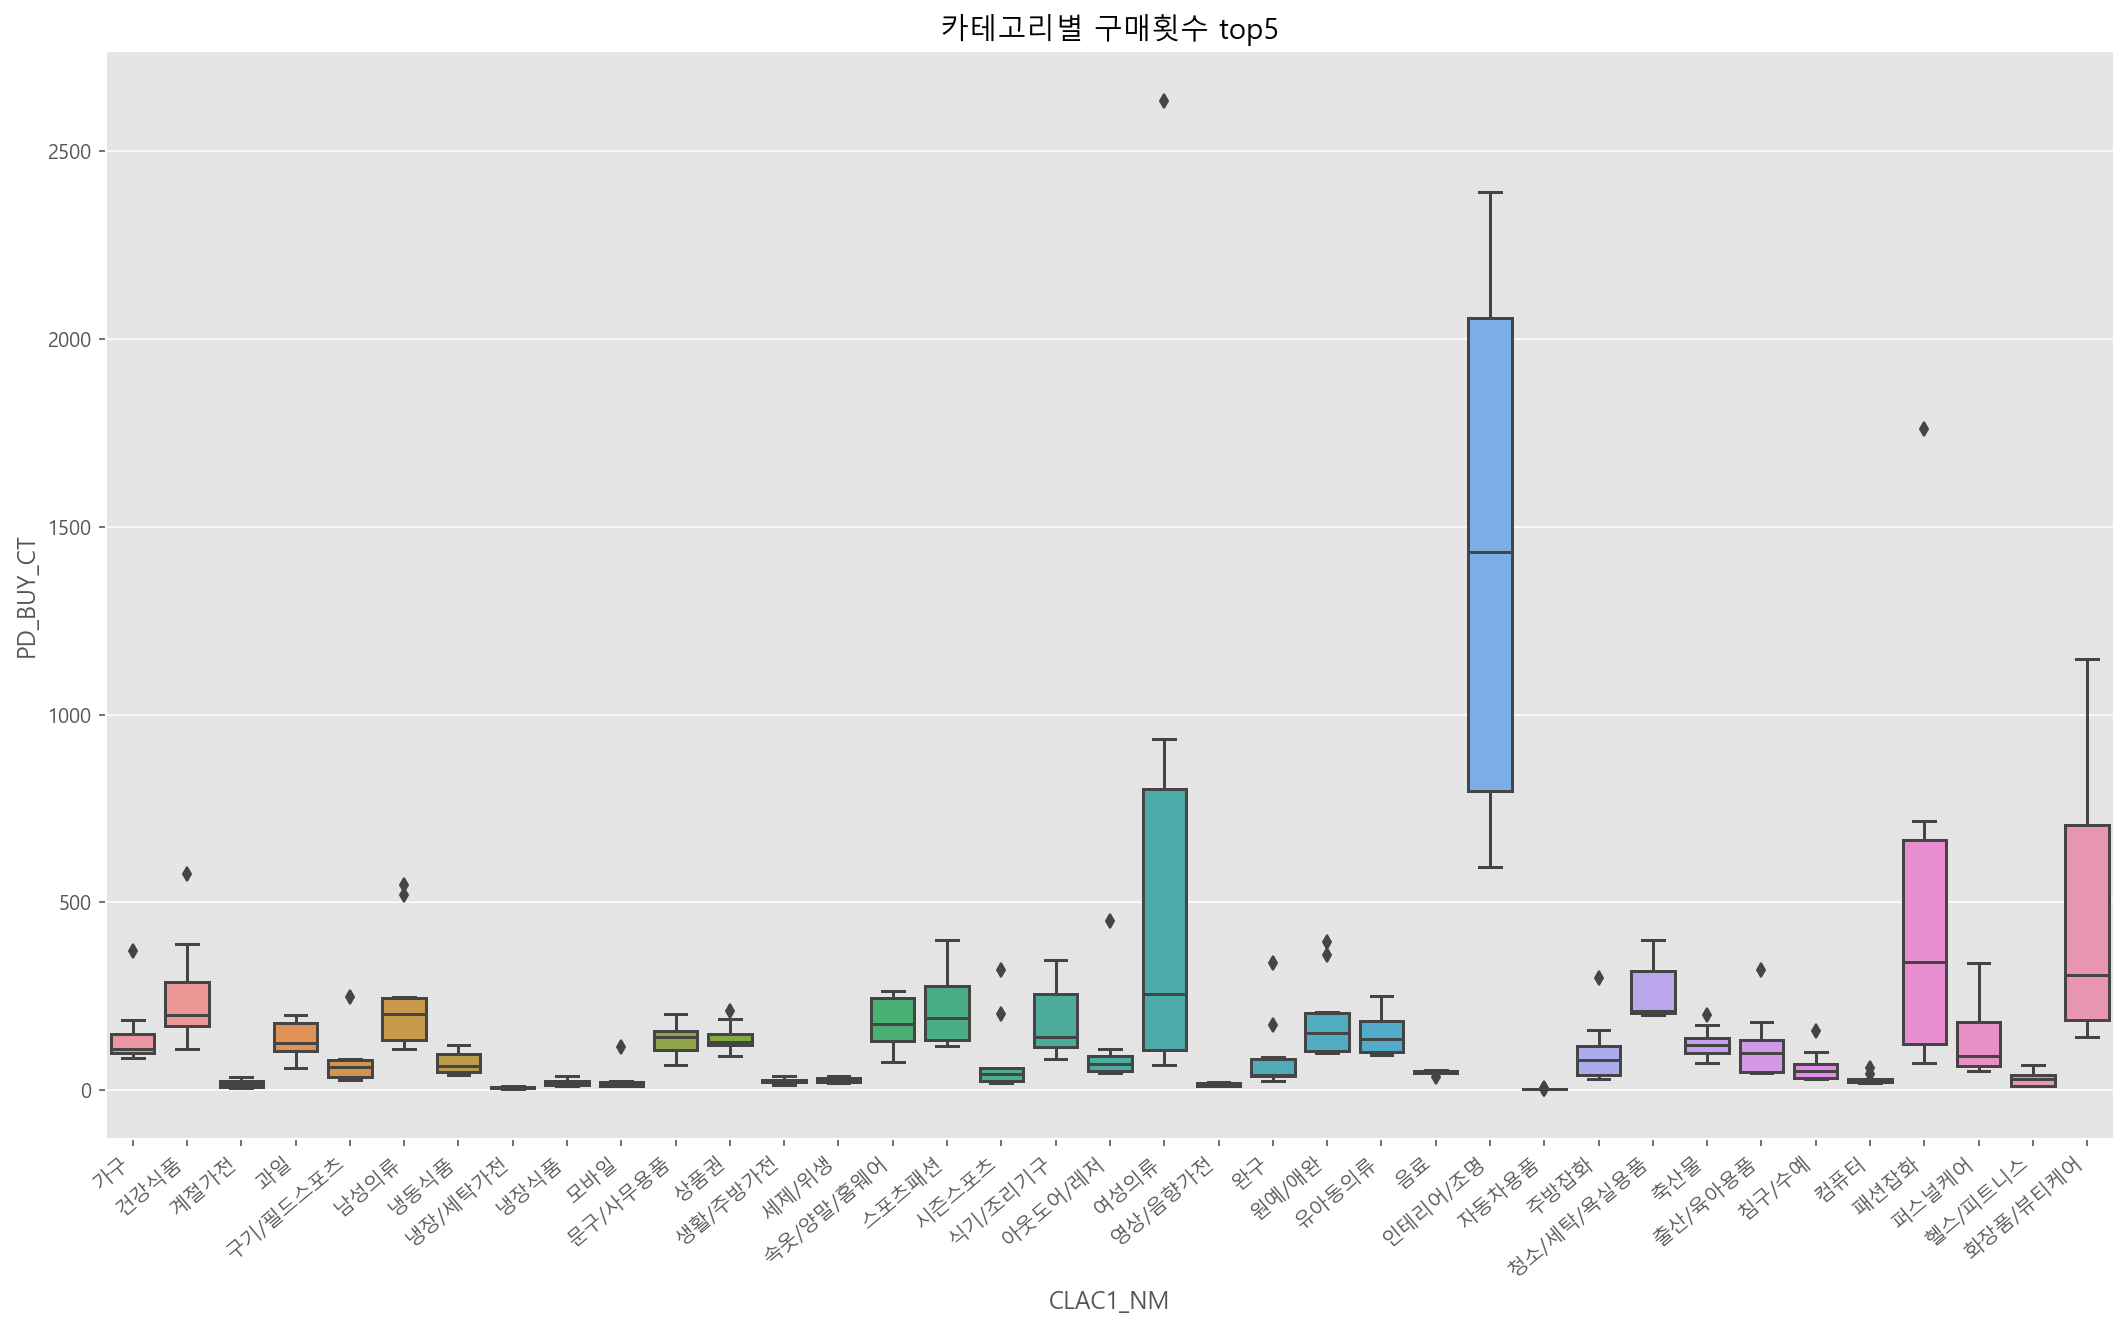

In [41]:
plt.figure(figsize=(18,10))
plt.xticks(rotation=40,ha='right')
sns.boxplot(data=result,x='CLAC1_NM',y='PD_BUY_CT')
plt.title("카테고리별 구매횟수 top5")   # 인테리어/조명은 구매하는 사람은 적지만 한번에 많은 수량을 구매한다는 것을 알 수 있다.

인테리어/조명 같은 경우에는 예를들어 커튼 1개가 가로100,세로100이지만
주문자가 500,200을 주문할 경우 10개가 되므로 판매 횟수가 늘어나는 구조이다.

In [ ]:
plt.figure(figsize=(18,10))
plt.xticks(rotation=40,ha='right')
sns.boxplot(data=result,x='CLAC1_NM',y='PD_BUY_CT',hue='CLNT_GENDER')
plt.title("남/여 카테고리별 구매횟수 top5")

# Ⅳ. 행동 패턴

## ⅰ. 기기별 이용고객 분석

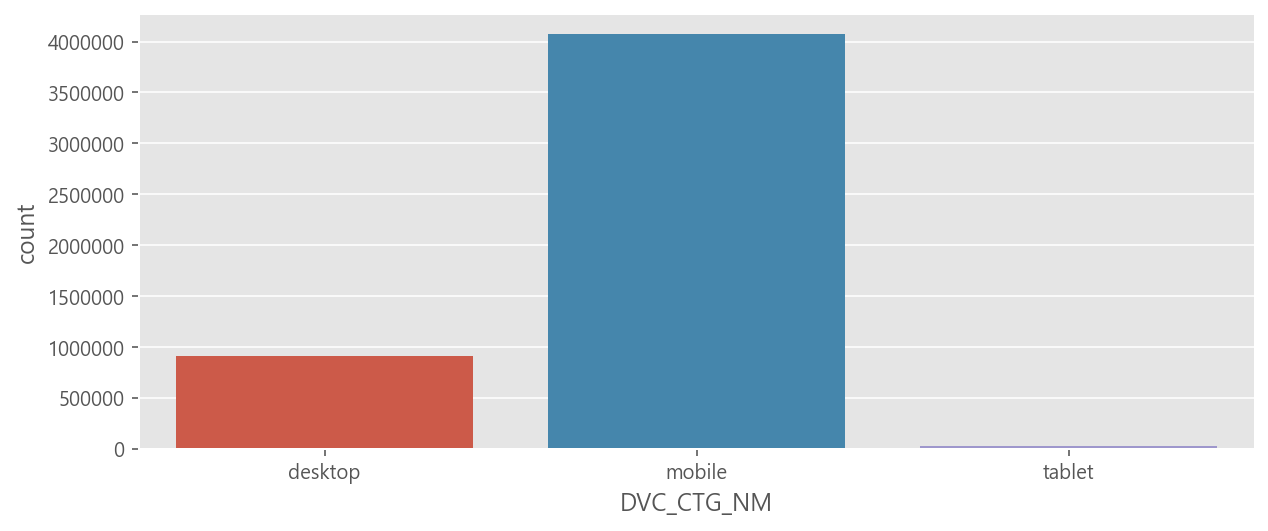

In [65]:
plt.figure(figsize=[10,4])
sns.countplot(data=pscm,x='DVC_CTG_NM')

모바일로 사이트를 이용하는 사람이 훨씬 많다.

- desktop 과 mobile의 연령대 비교

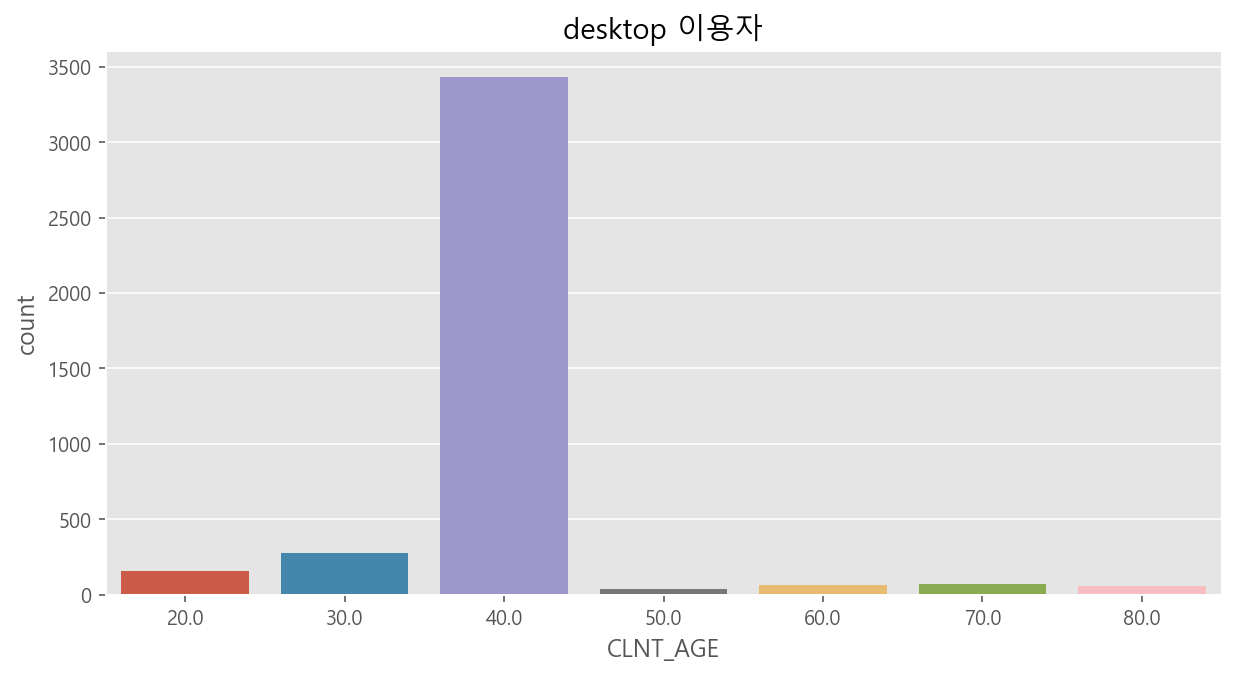

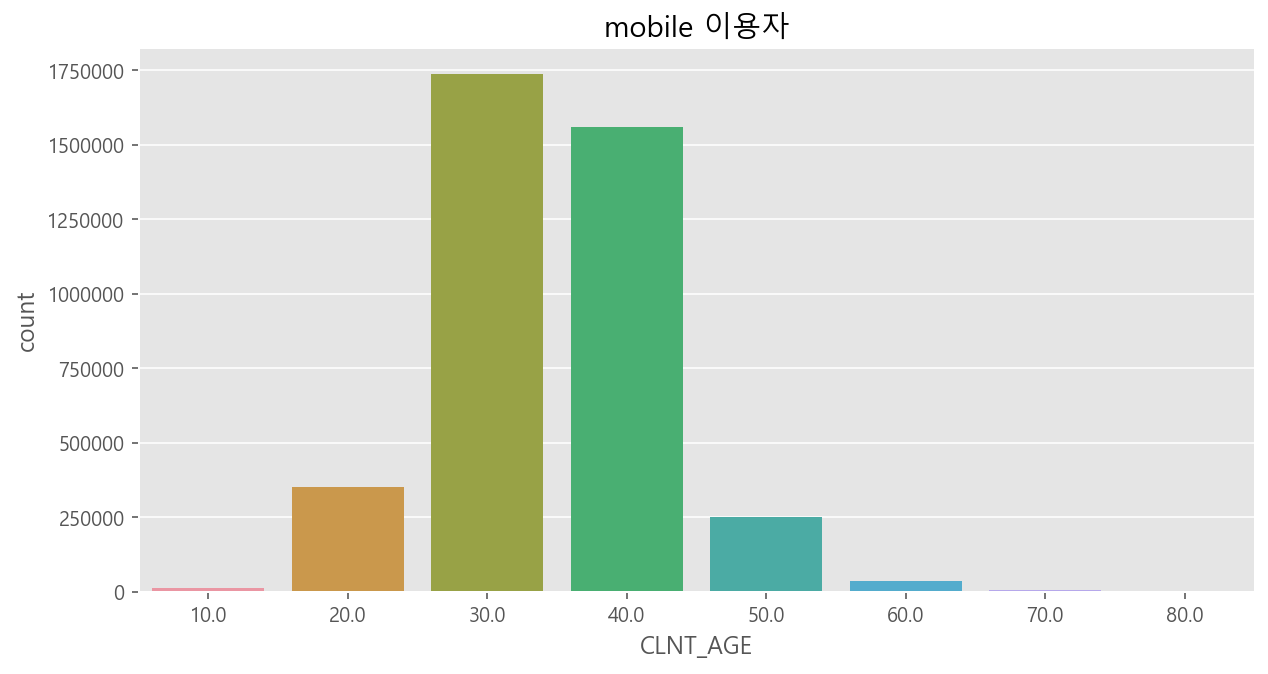

In [61]:
plt.figure(figsize=(10,5))
sns.countplot(data = pscm[pscm['DVC_CTG_NM']=='desktop'],
             x='CLNT_AGE')
plt.title('desktop 이용자')
plt.show()
plt.figure(figsize=(10,5))
sns.countplot(data = pscm[pscm['DVC_CTG_NM']=='mobile'],
             x='CLNT_AGE')
plt.title('mobile 이용자')
plt.show()

Text(0.5, 1.0, 'desktop 고객의 세션 총 시간 분포')

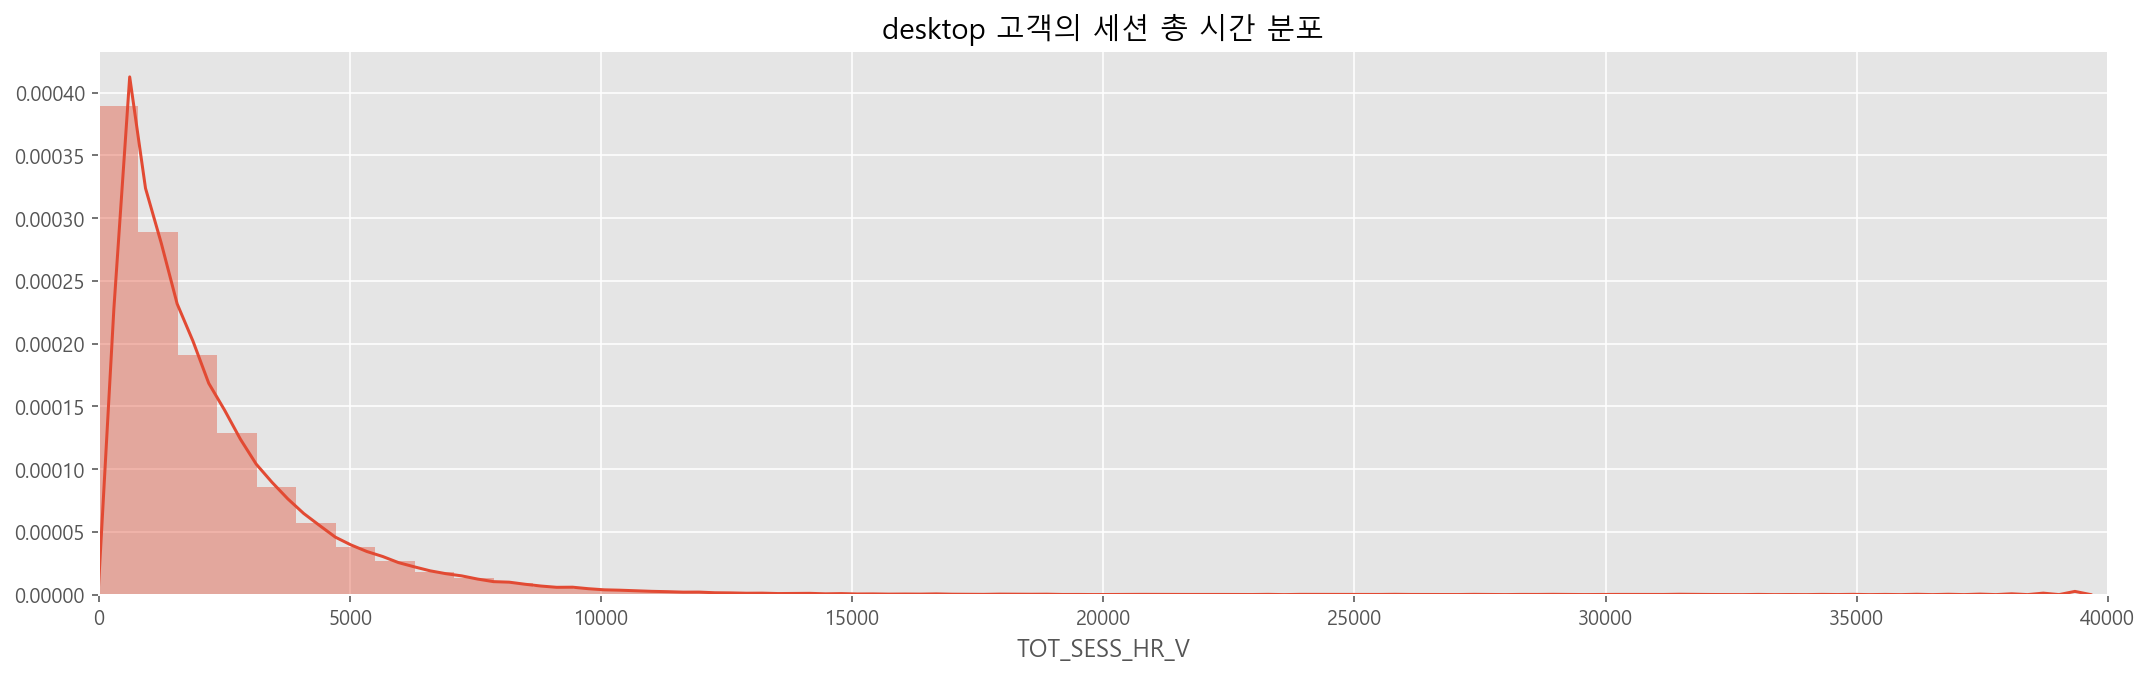

In [77]:
plt.figure(figsize=(18,5))
sns.distplot(pscm[pscm['DVC_CTG_NM']=='desktop']['TOT_SESS_HR_V'])
plt.xlim(0,40000)
plt.title('desktop 고객의 세션 총 시간 분포')

Text(0.5, 1.0, 'mobile 고객의 세션 총 시간 분포')

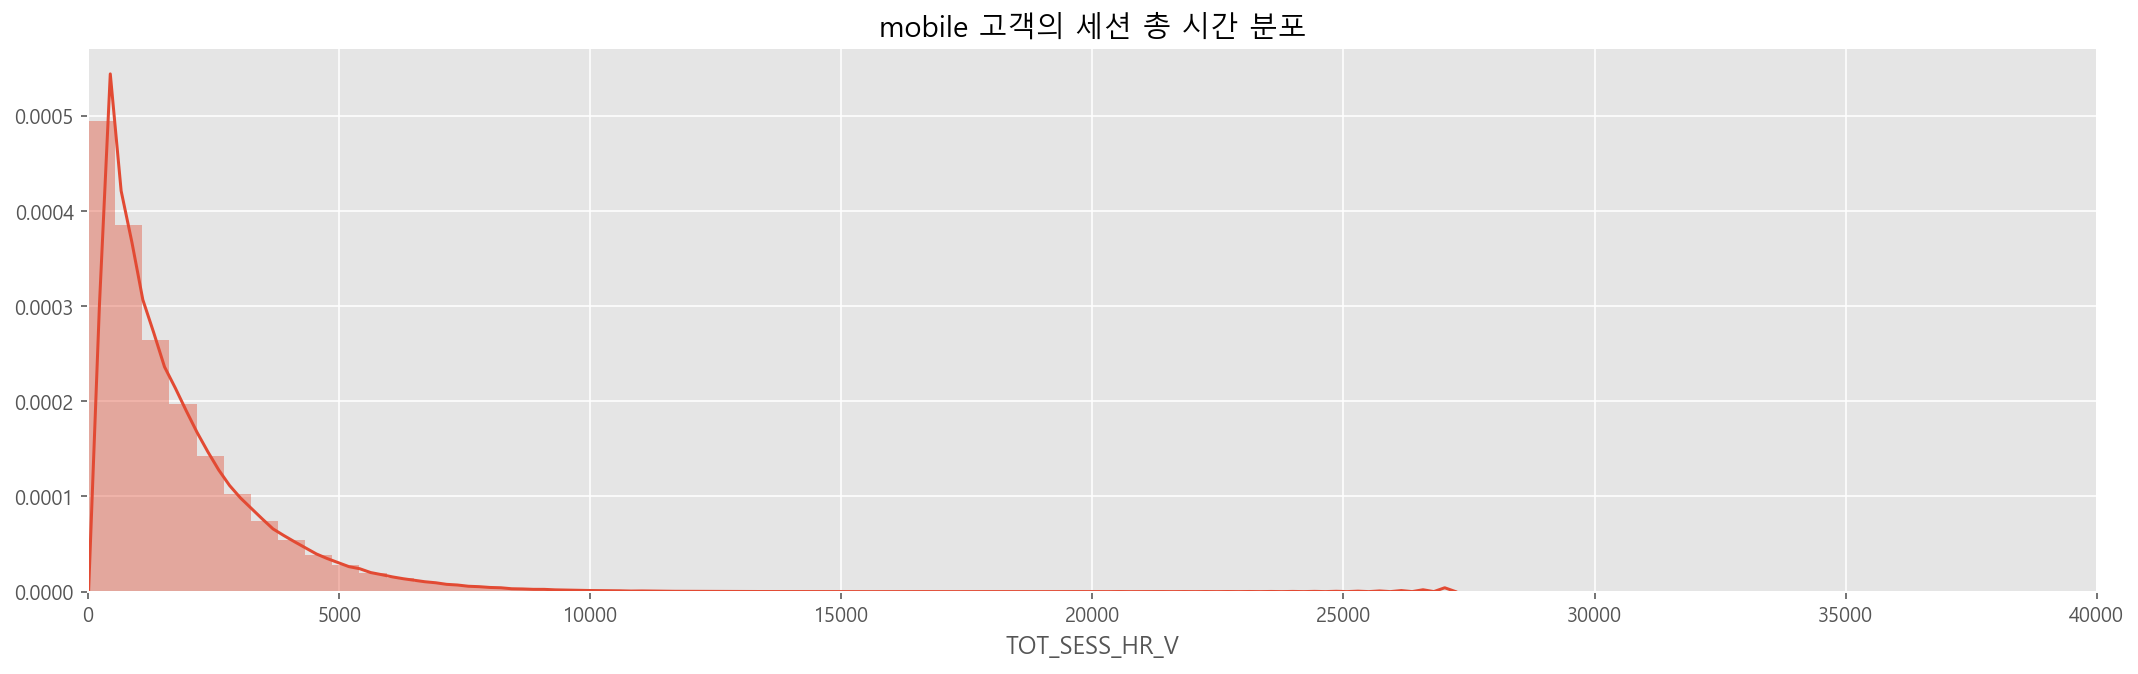

In [76]:
plt.figure(figsize=(18,5))
sns.distplot(pscm[pscm['DVC_CTG_NM']=='mobile']['TOT_SESS_HR_V'])
plt.xlim(0,40000)
plt.title('mobile 고객의 세션 총 시간 분포')

결론 : 

모바일 이용 고객이 데스크탑 고객보다 많다.

데스크탑 이용자 중에서는 40대가 가장 많다. (모바일에 익숙하지 않은 세대)

시간의 분포는 모바일이 데스크탑보다 조금 왼쪽에 분포되어있다. 데스크탑 이용자들이 좀더 사이트에 오래 머물러 있다는 뜻이다.
